# TESTING PLOTLY SCIKIT-LEARN FEATURES

In [1]:
%%bash
cd ames_data/
cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

	20	1-STORY 1946 & NEWER ALL STYLES
	30	1-STORY 1945 & OLDER
	40	1-STORY W/FINISHED ATTIC ALL AGES
	45	1-1/2 STORY - UNFINISHED ALL AGES
	50	1-1/2 STORY FINISHED ALL AGES
	60	2-STORY 1946 & NEWER
	70	2-STORY 1945 & OLDER
	75	2-1/2 STORY ALL AGES
	80	SPLIT OR MULTI-LEVEL
	85	SPLIT FOYER
	90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
LotFrontage: Linear feet of street connected to

### [Kaggle scoring metric](https://www.kaggle.com/c/house-prices-advanced-regression-techniques#evaluation)

"Submissions are evaluated on **Root-Mean-Squared-Error (RMSE) between the logarithm** of the predicted value and the logarithm of the observed sales price. (**Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.**)"



[MAE and RMSE — Which Metric is Better?](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d) 

"Taking the square root of the average squared errors has some interesting implications for RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. **This means the RMSE should be more useful when large errors are particularly undesirable.**"

### Submissions


"So what Kaggle does is to itself split the data into a training set and a test set. They release these to us and the training set contains the outcomes to predict, the test set does not. So the short answer is that you submit your outcome list for the test set that Kaggle has given you. What Kaggle does is to take your guesses and apply it to a random 50% of the test set and give you your results back (the exact metric used changes and can be found in the evaluation tab of the competition info). So during the competition you are getting feedback on a random static 50% of the test set. At the end of the competition they release how you went on the other 50% for your chosen top 2 guesses. So one thing to watch out for is overfitting on the 50% of the test set during the competition itself - it is common to see quite big changes to the leader board once a competiton has finished because of this. Hope this makes sense!" - [link](https://www.kaggle.com/getting-started/9551)

### [submission page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit)

# Imports

In [4]:
# Initial imports
import IPython
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn base, preprocessing, model_selection, pipeline, metrics
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, train_test_split, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error

# Estimators
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge 
from sklearn.linear_model import Lasso # GridSearchCV instead of LassoCV since scoring is hard-coded as MSE
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

/Users/austin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



Version checks

In [6]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
IPython.__version__

Darwin-17.2.0-x86_64-i386-64bit
Python 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
NumPy 1.13.3
SciPy 0.19.1
Scikit-Learn 0.19.0


'6.1.0'

# Options

In [8]:
# Magics
%matplotlib inline

# Turn on multiple cell output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Increase number of rows to print
pd.options.display.max_rows = 500

# Numpy random seed
np.random.seed(42)

# Turn off SettingWithCopyWarning 
#pd.options.mode.chained_assignment = None


# Shift-Tab on highlighted function for info!

#### Sample Submission

In [9]:
sample_submission = pd.read_csv("ames_data/sample_submission.csv")
sample_submission.head()
sample_submission.tail()
sample_submission.shape
# includes header, so should be 1460 lines long

Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977

Id      SalePrice
1454  2915  167081.220949
1455  2916  164788.778231
1456  2917  219222.423400
1457  2918  184924.279659
1458  2919  187741.866657

(1459, 2)

# Reading in the data
### Parsing twice and performing checks

In [11]:
# According to description, columns where "NA" is an actual possible value rather than a missing value
legit_NA_cols = ["BsmtCond", "BsmtQual", "GarageCond", "GarageQual", "GarageType", "Alley", "FireplaceQu", 
                      "MiscFeature", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish", "PoolQC", "Fence"]

In [12]:
# read in data features with legitimate "NA" values
legit_train = pd.read_csv('ames_data/train.csv', usecols=legit_NA_cols, keep_default_na=False)
legit_test = pd.read_csv('ames_data/test.csv', usecols=legit_NA_cols, keep_default_na=False)

# add features that don't have possible "NA" values, so "NA" is replaced with "NaN"
train = pd.read_csv('ames_data/train.csv').assign(**legit_train)
test = pd.read_csv('ames_data/test.csv').assign(**legit_test)

# replace empty strings with NaNs
train.replace('', np.NaN, inplace=True)
test.replace('', np.NaN, inplace=True)

In [13]:
# Make sure NA is a possible value for the first legit_NA_cols feature in train
print("\n'NA' in BsmtCond? ","NA" in list(train[legit_NA_cols[0]].value_counts().index))

# Make sure sum of NaNs is not zero
print("\nSum of NaN counts over all features in train: ", train.isnull().sum().sum())
print("Sum of NaN counts over all features in test: ", test.isnull().sum().sum())


'NA' in BsmtCond?  True

Sum of NaN counts over all features in train:  357
Sum of NaN counts over all features in test:  358


### Missing features in train and test

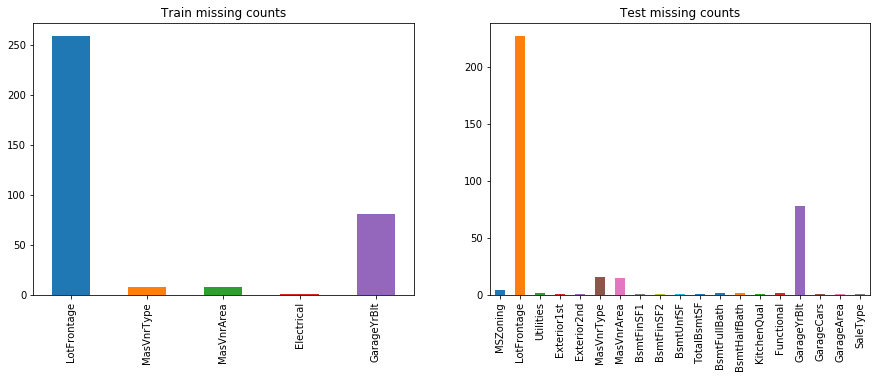

In [14]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
train.isnull().sum()[train.isnull().sum() > 0].plot(kind="bar",ax=axes[0]); # supress info with semicolon
axes[0].set_title("Train missing counts");
test.isnull().sum()[test.isnull().sum() > 0].plot(kind="bar",ax=axes[1]);
axes[1].set_title("Test missing counts");

In [15]:
# list features with missing values in train and test
train_null_features = train.columns[train.isnull().sum() > 0].tolist()
test_null_features = test.columns[test.isnull().sum() > 0].tolist()

**Observations: ** The testing data has more features with missing values than the training data. I'll need to be careful in making decisions on what missing data to drop and what to impute. I can't simply drop observations with missing values from the training data, because the test submission must contain all observations, and the drop/impute decisions should agree across both sets of data.

## Checking feature types

### Manually sorting features by type

In [16]:
ID = ['Id']

# regular continous numbers
contin_num_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                   'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                   '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 
                   'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                   'ScreenPorch', 'PoolArea', 'MiscVal']

# these are discrete
discrete_num_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'BedroomAbvGr', 
                     'KitchenAbvGr',]

# these are interval
ordinal_num_cols = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                    'GarageYrBlt', 'YrSold']

# nominal (class numbers)
categorical_num_cols = ['MSSubClass', 'MoSold']

#17
# have to give ordinal strings custom mappings
ordinal_string_cols = ['Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
                       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                       'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 
                       'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
                       'PavedDrive', 'PoolQC', 'Fence']

# nominal (class) strings
categorical_string_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
                           'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 
                           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                           'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
                           'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
                           'SaleType', 'SaleCondition']

# dependent variable
target = ['SalePrice']

#### Check that I didn't miss or incorrectly name any features



In [17]:
# all features in test data
features_list = test.columns.tolist()

# all features from manually sorted categories
features_manually_sorted = (ID + contin_num_cols + discrete_num_cols + ordinal_num_cols 
                            + categorical_num_cols + ordinal_string_cols + categorical_string_cols)

# initial check to make sure length is correct
len(features_list) ==  len(features_manually_sorted)

# make sure I've included everything
len(list(set(features_manually_sorted) - set(features_list))) == 0
len(list(set(features_list) - set(features_manually_sorted))) == 0

True

True

True

In [18]:
len(features_list)

80

#### Check default types against manually sorted lists

In [19]:
# numeric/string feature lists for manually sorted lists from above
numeric_features_manual = ID + contin_num_cols + discrete_num_cols + ordinal_num_cols + categorical_num_cols
string_features_manual = ordinal_string_cols + categorical_string_cols

# numeric/string features lists for default data types
numeric_features_default = test.select_dtypes(['int', 'float']).columns
string_features_default = test.select_dtypes(['object']).columns

# check that these are equal for all three
len(numeric_features_manual)+len(string_features_manual) == len(numeric_features_default)+len(string_features_default)
set(numeric_features_manual) == set(numeric_features_default)
set(string_features_manual) == set(string_features_default)

True

True

True

# Dealing with missing values

### Split X and y, combine test and train data for imputation values

In [20]:
IDtrain = train.Id
ytrain = train.SalePrice
Xtrain = train.drop(ID+target, axis=1)

IDtest = test.Id
Xtest = test.drop(ID, axis=1)

XTrainTest = pd.concat([Xtrain, Xtest])
XTrainTest.head()
XTrainTest.shape

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave    NA      Reg   
1          20       RL         80.0     9600   Pave    NA      Reg   
2          60       RL         68.0    11250   Pave    NA      IR1   
3          70       RL         60.0     9550   Pave    NA      IR1   
4          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities LotConfig      ...       ScreenPorch PoolArea PoolQC  \
0         Lvl    AllPub    Inside      ...                 0        0     NA   
1         Lvl    AllPub       FR2      ...                 0        0     NA   
2         Lvl    AllPub    Inside      ...                 0        0     NA   
3         Lvl    AllPub    Corner      ...                 0        0     NA   
4         Lvl    AllPub       FR2      ...                 0        0     NA   

  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0    NA          NA       0       2    2008        WD         Normal  
1    NA          NA       0       5    2007        WD         Normal  
2    NA          NA       0       9    2008        WD         Normal  
3    NA          NA       0       2    2006        WD        Abnorml  
4    NA          NA       0      12    2008        WD         Normal  

[5 rows x 79 columns]

(2919, 79)

#### Additional feature preparation

In [21]:
# Features to handle separately
NA_means_0_cols = ["LotFrontage"]
NA_add_indicator = ["GarageYrBlt"]

# Set of possible values for categorical/ordinal features from training and test data
cat_cols_all = categorical_num_cols + categorical_string_cols
ord_cols_all = ordinal_num_cols + ordinal_string_cols

# Determine categorical features carrying very little information (97% or data is a single category)
low_var_cats = [col for col in cat_cols_all+ord_cols_all if 1 - sum(Xtrain[col] == Xtrain[col].mode()[0])/len(Xtrain) < 0.03]
low_var_cats

# Determine features from training set with more than a quarter missing to remove
more_than_quarter_missing = Xtrain.columns[Xtrain.isnull().sum() > Xtrain.shape[0]*0.25].tolist()

# to drop
drop_features = low_var_cats + more_than_quarter_missing

['Street', 'Condition2', 'RoofMatl', 'Heating', 'Utilities', 'PoolQC']

#### Update feature lists

In [22]:
# for each feature list, remove values in dropped list
contin_num_cols = list(set(contin_num_cols) - set(drop_features))
discrete_num_cols = list(set(discrete_num_cols) - set(drop_features))
ordinal_num_cols = list(set(ordinal_num_cols) - set(drop_features))
categorical_num_cols = list(set(categorical_num_cols) - set(drop_features))
ordinal_string_cols = sorted(list(set(ordinal_string_cols) - set(drop_features)))
categorical_string_cols = list(set(categorical_string_cols) - set(drop_features))

cat_cols_all = list(set(cat_cols_all) - set(drop_features))
ord_cols_all = list(set(ord_cols_all) - set(drop_features))

### Data cleaning and imputation class

In [23]:
class CleanTransformer(TransformerMixin):
    
    def __init__(self):
        """Going to try and add:
        - drop low var features (low_var_cats)
        - drop more_than_quarter_missing
        - replace NA with 0 for specific cols
        - add indicator var for specific cols
        - impute missing values 
        """
        
    def fit(self, XTrainTestCombo, NA_means_0_cols, NA_add_indicator, low_var_cats, more_than_quarter_missing):
        
        self.fill = pd.Series([XTrainTestCombo[f].mode()[0] if XTrainTestCombo[f].dtype == np.dtype('O') 
                     else XTrainTestCombo[f].median() for f in XTrainTestCombo], index=XTrainTestCombo.columns)
        self.NA_means_0_cols = NA_means_0_cols
        self.NA_add_indicator = NA_add_indicator
        self.low_var_cats = low_var_cats
        self.more_than_quarter_missing = more_than_quarter_missing
        return self

    def transform(self, X):
        
        # drop low variance features
        X = X.drop(self.low_var_cats, axis=1)  
        # drop features with many missing
        X = X.drop(self.more_than_quarter_missing, axis=1)
        # Replace NA with 0 for specific cols
        X[self.NA_means_0_cols] = X[self.NA_means_0_cols].fillna(0, axis=1)
        # Add indicator variable for specific cols
        for c in self.NA_add_indicator:
            X[c + "_indicator"] = X[c].isnull().astype('int64')
        # impute values from fit
        X = X.fillna(self.fill) 
        return X

### Fit and transform cleaning class on train and test data, check null counts

In [24]:
# cleaner object
cleaner = CleanTransformer();

# check null counts
print("Xtrain null count before cleaning: ", Xtrain.isnull().sum().sum())
print("Xtest null count before cleaning: ", Xtest.isnull().sum().sum())

# fit cleaner
cleaner.fit(XTrainTest, NA_means_0_cols, NA_add_indicator, low_var_cats, more_than_quarter_missing);

# clean Xtrain and Xtest
Xtrain = cleaner.transform(Xtrain);
Xtest = cleaner.transform(Xtest);

# recheck null counts
print("Xtrain null count after cleaning: ", Xtrain.isnull().sum().sum())
print("Xtest null count after cleaning: ", Xtest.isnull().sum().sum())

Xtrain null count before cleaning:  357
Xtest null count before cleaning:  358


Xtrain null count after cleaning:  0
Xtest null count after cleaning:  0


In [25]:
# check out dataframes
Xtrain.head()
Xtest.head()

MSSubClass MSZoning  LotFrontage  LotArea Alley LotShape LandContour  \
0          60       RL         65.0     8450    NA      Reg         Lvl   
1          20       RL         80.0     9600    NA      Reg         Lvl   
2          60       RL         68.0    11250    NA      IR1         Lvl   
3          70       RL         60.0     9550    NA      IR1         Lvl   
4          60       RL         84.0    14260    NA      IR1         Lvl   

  LotConfig LandSlope Neighborhood          ...          ScreenPorch PoolArea  \
0    Inside       Gtl      CollgCr          ...                    0        0   
1       FR2       Gtl      Veenker          ...                    0        0   
2    Inside       Gtl      CollgCr          ...                    0        0   
3    Corner       Gtl      Crawfor          ...                    0        0   
4       FR2       Gtl      NoRidge          ...                    0        0   

  Fence  MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  \
0    NA           NA        0       2    2008       WD        Normal   
1    NA           NA        0       5    2007       WD        Normal   
2    NA           NA        0       9    2008       WD        Normal   
3    NA           NA        0       2    2006       WD       Abnorml   
4    NA           NA        0      12    2008       WD        Normal   

  GarageYrBlt_indicator  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 74 columns]

MSSubClass MSZoning  LotFrontage  LotArea Alley LotShape LandContour  \
0          20       RH         80.0    11622    NA      Reg         Lvl   
1          20       RL         81.0    14267    NA      IR1         Lvl   
2          60       RL         74.0    13830    NA      IR1         Lvl   
3          60       RL         78.0     9978    NA      IR1         Lvl   
4         120       RL         43.0     5005    NA      IR1         HLS   

  LotConfig LandSlope Neighborhood          ...          ScreenPorch PoolArea  \
0    Inside       Gtl        NAmes          ...                  120        0   
1    Corner       Gtl        NAmes          ...                    0        0   
2    Inside       Gtl      Gilbert          ...                    0        0   
3    Inside       Gtl      Gilbert          ...                    0        0   
4    Inside       Gtl      StoneBr          ...                  144        0   

   Fence  MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  \
0  MnPrv           NA        0       6    2010       WD        Normal   
1     NA         Gar2    12500       6    2010       WD        Normal   
2  MnPrv           NA        0       3    2010       WD        Normal   
3     NA           NA        0       6    2010       WD        Normal   
4     NA           NA        0       1    2010       WD        Normal   

  GarageYrBlt_indicator  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 74 columns]

#### recombine cleaned Xtrain and ytrain for plotting

In [26]:
train = pd.concat([Xtrain, ytrain], axis=1)

# Initial Data Exploration

### Data descriptions:

In [27]:
print("Train data description:")
Xtrain.describe()
print("Test data description:")
Xtest.describe()

print('SalePrice description:')
ytrain.describe()

Train data description:


MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    57.623288   10516.828082     6.099315     5.575342   
std      42.300571    34.664304    9981.264932     1.382997     1.112799   
min      20.000000     0.000000    1300.000000     1.000000     1.000000   
25%      20.000000    42.000000    7553.500000     5.000000     5.000000   
50%      50.000000    63.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000   
mean   1971.267808   1984.865753   103.117123   443.639726    46.549315   
std      30.202904     20.645407   180.731373   456.098091   161.319273   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000   
75%    2000.000000   2004.000000   164.250000   712.250000     0.000000   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000   

               ...             WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count          ...            1460.000000  1460.000000    1460.000000   
mean           ...              94.244521    46.660274      21.954110   
std            ...             125.338794    66.256028      61.119149   
min            ...               0.000000     0.000000       0.000000   
25%            ...               0.000000     0.000000       0.000000   
50%            ...               0.000000    25.000000       0.000000   
75%            ...             168.000000    68.000000       0.000000   
max            ...             857.000000   547.000000     552.000000   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold  \
count  1460.000000  1460.000000  1460.000000   1460.000000  1460.000000   
mean      3.409589    15.060959     2.758904     43.489041     6.321918   
std      29.317331    55.757415    40.177307    496.123024     2.703626   
min       0.000000     0.000000     0.000000      0.000000     1.000000   
25%       0.000000     0.000000     0.000000      0.000000     5.000000   
50%       0.000000     0.000000     0.000000      0.000000     6.000000   
75%       0.000000     0.000000     0.000000      0.000000     8.000000   
max     508.000000   480.000000   738.000000  15500.000000    12.000000   

            YrSold  GarageYrBlt_indicator  
count  1460.000000            1460.000000  
mean   2007.815753               0.055479  
std       1.328095               0.228992  
min    2006.000000               0.000000  
25%    2007.000000               0.000000  
50%    2008.000000               0.000000  
75%    2009.000000               0.000000  
max    2010.000000               1.000000  

[8 rows x 37 columns]

Test data description:


MSSubClass  LotFrontage       LotArea  OverallQual  OverallCond  \
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000   
mean     57.378341    57.910212   9819.161069     6.078821     5.553804   
std      42.746880    32.266054   4955.517327     1.436812     1.113740   
min      20.000000     0.000000   1470.000000     1.000000     1.000000   
25%      20.000000    44.000000   7391.000000     5.000000     5.000000   
50%      50.000000    63.000000   9399.000000     6.000000     5.000000   
75%      70.000000    78.000000  11517.500000     7.000000     6.000000   
max     190.000000   200.000000  56600.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1459.000000   1459.000000  1459.000000  1459.000000  1459.000000   
mean   1971.357779   1983.662783    99.673749   439.155243    52.583276   
std      30.390071     21.130467   177.001792   455.115652   176.698671   
min    1879.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1953.000000   1963.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1992.000000     0.000000   351.000000     0.000000   
75%    2001.000000   2004.000000   162.000000   752.000000     0.000000   
max    2010.000000   2010.000000  1290.000000  4010.000000  1526.000000   

               ...             WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count          ...            1459.000000  1459.000000    1459.000000   
mean           ...              93.174777    48.313914      24.243317   
std            ...             127.744882    68.883364      67.227765   
min            ...               0.000000     0.000000       0.000000   
25%            ...               0.000000     0.000000       0.000000   
50%            ...               0.000000    28.000000       0.000000   
75%            ...             168.000000    72.000000       0.000000   
max            ...            1424.000000   742.000000    1012.000000   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold  \
count  1459.000000  1459.000000  1459.000000   1459.000000  1459.000000   
mean      1.794380    17.064428     1.744345     58.167923     6.104181   
std      20.207842    56.609763    30.491646    630.806978     2.722432   
min       0.000000     0.000000     0.000000      0.000000     1.000000   
25%       0.000000     0.000000     0.000000      0.000000     4.000000   
50%       0.000000     0.000000     0.000000      0.000000     6.000000   
75%       0.000000     0.000000     0.000000      0.000000     8.000000   
max     360.000000   576.000000   800.000000  17000.000000    12.000000   

            YrSold  GarageYrBlt_indicator  
count  1459.000000            1459.000000  
mean   2007.769705               0.053461  
std       1.301740               0.225029  
min    2006.000000               0.000000  
25%    2007.000000               0.000000  
50%    2008.000000               0.000000  
75%    2009.000000               0.000000  
max    2010.000000               1.000000  

[8 rows x 37 columns]

SalePrice description:


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## Qualitative Features (nominal [categorical] and ordinal)

In [28]:
# check object features
obj_features_train = Xtrain.select_dtypes(['object']).columns.tolist()
obj_features_test = Xtest.select_dtypes(['object']).columns.tolist()
print("Same object-type features in train and test by default? ", obj_features_train == obj_features_test)

# select all categorical and ordinal features for box plots
cat_ord_features = obj_features_train + categorical_num_cols + ordinal_num_cols

Same object-type features in train and test by default?  True


### Box plots of qualitative versus SalePrice

/Users/austin/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



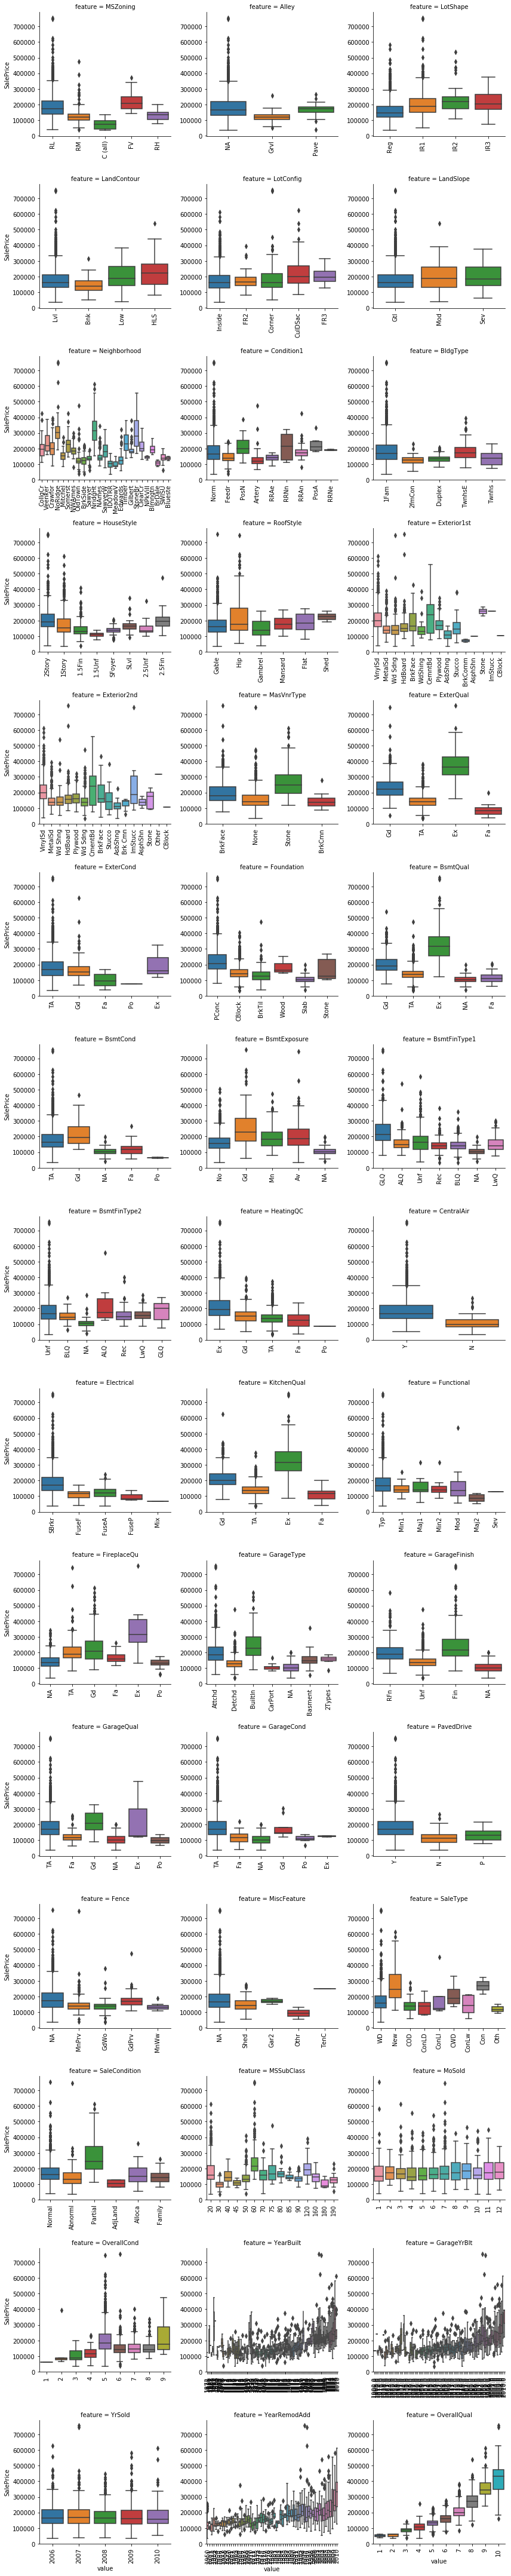

In [30]:
# generate the box plots (nice use of melt/FacetGrid adobted from Dominik GawlikHouse)
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=cat_ord_features, var_name='feature')
g = sns.FacetGrid(f, col="feature",  col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(boxplot, "value", "SalePrice")

Categorical/ordinal features that look to have a significant positive impact on SalePrice are:

- A couple of particular neighborhoods
- Excellent overall, exterior, kitchen, basement, pool, heating, and/or fireplace qualities
- More recent YearRemodAdd
- Stone masonry veneer type
- Wood Shingles as roofing material
- New homes or partial sales

I'll be transforming categorical features into N-1 dummy variable columns later on in the transformation step.

### <font color='green'> Detour: Standardizing dummy variables</font>

#### [CrossValidated: whether to rescale indicator / binary / dummy predictors](https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso)


Argument **for** standardizing dummy variables:
<img src="img/dummy standardizing 1.png" style="width:70%">

Argument **against** standardizing dummy variables:
<img src="img/dummy standardizing 2.png" style="width:70%">

I'm going to perform standardization in the transformations section. I'll try both standardizing all predictors and only standardizing quantitative predictors, and then I'll see which performs better in this case.

## Quantitative Features (discrete and continuous)

In [31]:
quantitative_features = list(set(contin_num_cols + discrete_num_cols) - set(target) - set(ordinal_num_cols) - set(categorical_num_cols))
len(quantitative_features)

28

### distplots (histograms + kernel density estimates)

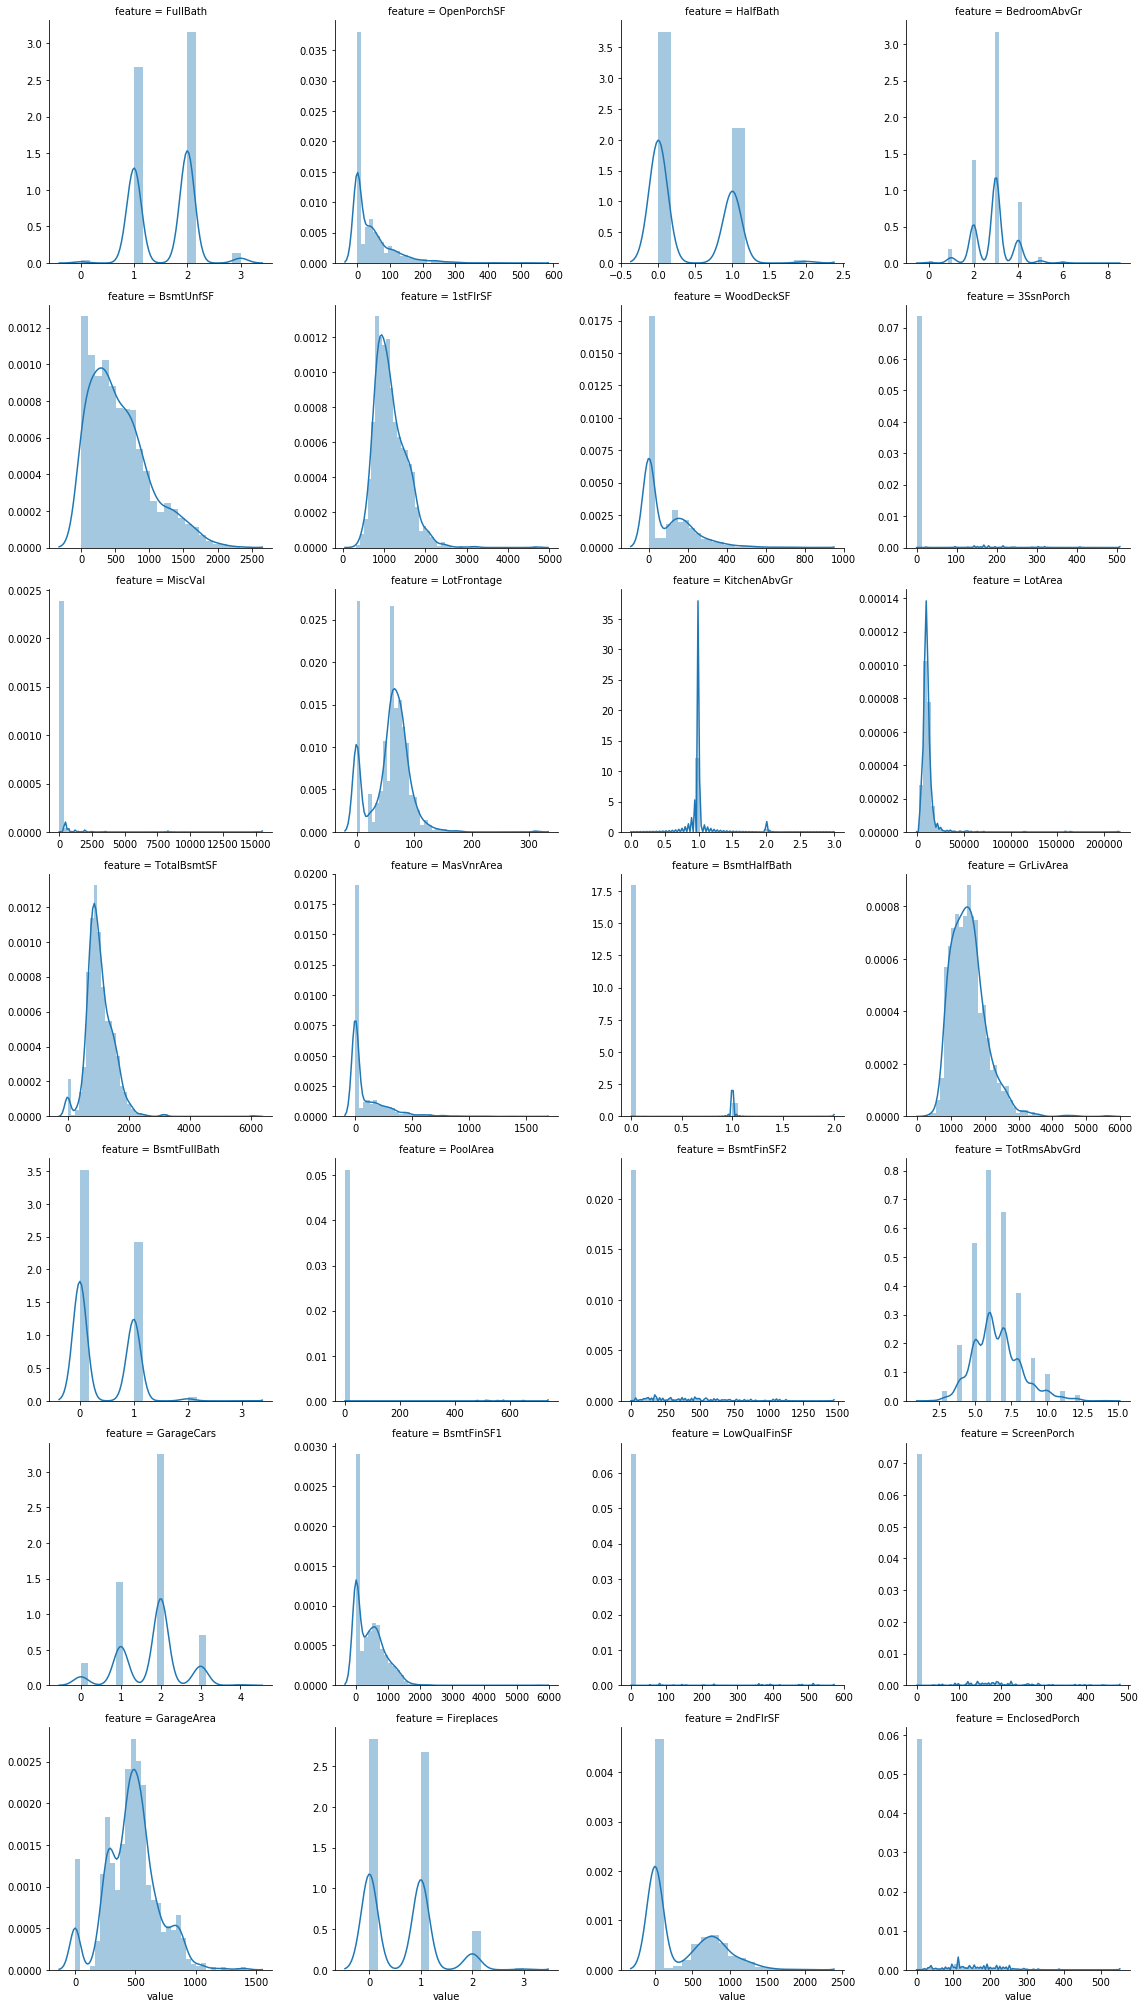

In [32]:
f = pd.melt(Xtrain, value_vars=quantitative_features, var_name='feature')
g = sns.FacetGrid(f, col="feature",  col_wrap=4, size=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### regplots (scatter + regression line) of quantitative features versus SalePrice

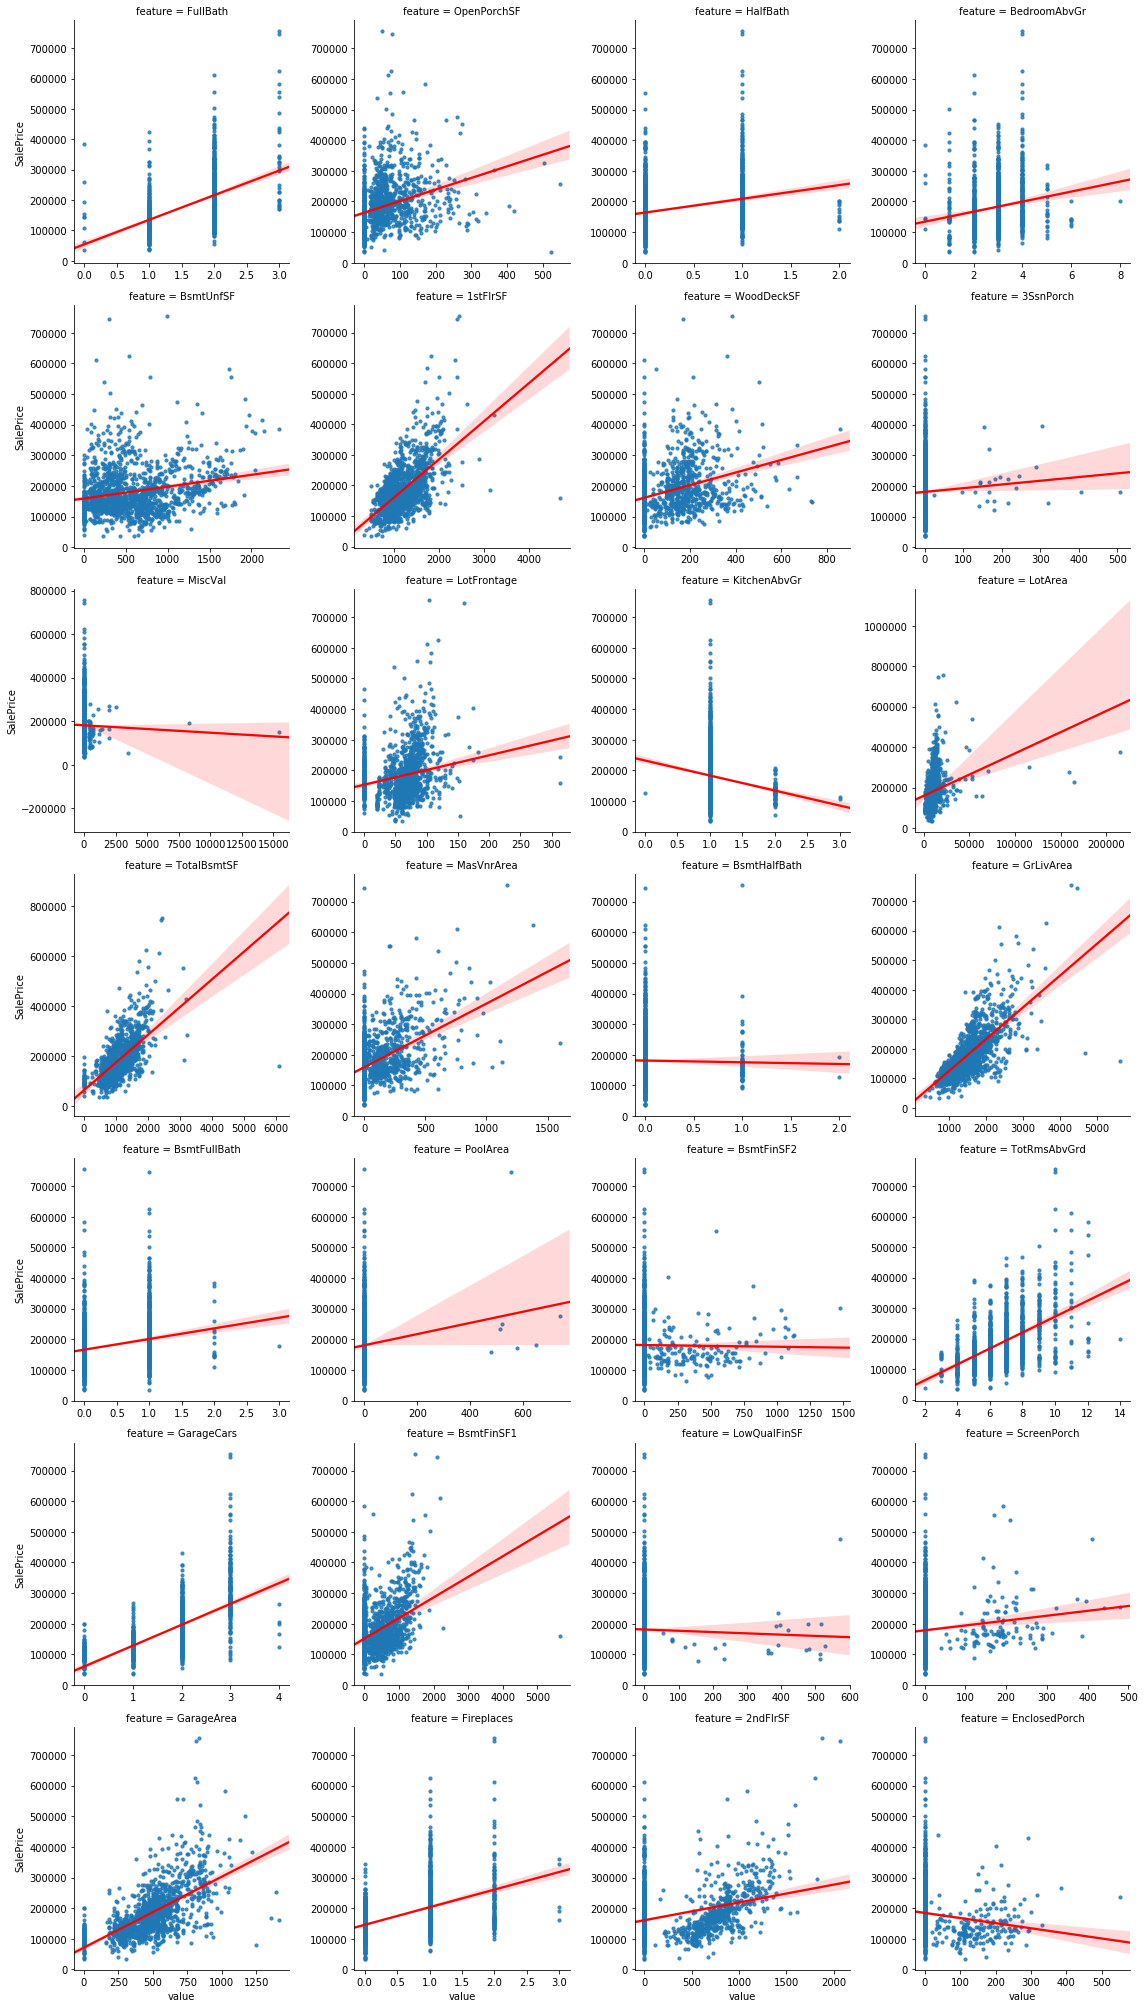

In [33]:
f = pd.melt(train, id_vars=['SalePrice'],value_vars=quantitative_features, var_name='feature')
g = sns.FacetGrid(f, col="feature",  col_wrap=4, size=4, sharex=False, sharey=False)
g = g.map(sns.regplot, "value", "SalePrice", scatter_kws={"s": 10}, line_kws={'color': 'red'})

### <font color='green'> Detour: Normality assumptions, errors and residuals, and log transformations</font>
<br>

- ## Does linear regression assume normality of variables?
    - [Assumptions of Multiple Regression: Correcting Two Misconceptions](http://pareonline.net/getvn.asp?v=18&n=11)  
**The Normality Assumption: It’s All About the Errors**  
        In their summary of the assumptions of multiple regression, the first of four assumptions given focus by Osborne and Waters (2002) is the normality assumption. Osborne and Waters state: “Regression assumes that variables have normal distributions” (p. 1). They do not explicate which variables in particular they are referring to, but the implication seems to be that multiple regression requires that the predictor and/or response variables be normally distributed. In reality, only the assumption of normally distributed errors is relevant to multiple regression: Specifically, we may assume that errors are normally distributed for any combination of values on the predictor variables.  

        It is important to define at this point what we mean by errors, especially as the term is unfortunately used to denote two different concepts that are relevant to a regression model. In a regression model, errors are the difference between subjects' observed values on the response variable and the values predicted by the true regression model for the population as a whole. This usage of the term error needs to be distinguished from the concept of measurement error, which will be defined and discussed later in this article.  

        The errors of a regression model cannot usually be directly observed, of course, since we rarely know the parameters of the true regression model. Instead, it is possible to investigate the properties of the errors by calculating the residuals of a regression model estimated using sample data (Weisberg, 2005). The residuals are defined as the differences between the observed response variable values and the values predicted by the estimated regression model. Another way of stating the normality assumption is that for any given combination of values on the predictor variables, we assume that the conditional distribution of the response variable is normal1—even though we do not assume that the marginal or “raw” distribution of the dependent variable is necessarily normal.  

    - [Should independent and dependent variables be normally distributed for linear regression?](https://www.quora.com/Should-independent-and-dependent-variables-be-normally-distributed-for-linear-regression)
        - "The x variables are conditioned on and thus, strictly speaking, their distribution doesn't matter at all. However, in practice if one or more of the independent variables is strongly skewed, it's likely to be a problem. These points are called high leverage points and are essentially outliers in the space of X."

<br>


- ## Why check residuals when normality of error is the assumption of regression analysis?
    - [What is the difference between errors and residuals?](https://stats.stackexchange.com/questions/133389/what-is-the-difference-between-errors-and-residuals)
        - "Residuals can be considered estimates of the errors."
    - [What is the difference between error terms and residuals in econometrics (or in regression models)?](https://www.researchgate.net/post/What_is_the_difference_between_error_terms_and_residuals_in_econometrics_or_in_regression_models)
    - [Is the residual, e, an estimator of the error, ϵ?](https://stats.stackexchange.com/questions/72392/is-the-residual-e-an-estimator-of-the-error-epsilon)
    - [Interpreting residual plots to improve your regression](http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/)
    - [Difference between Residual and Disturbance (epsilon)](https://stats.stackexchange.com/questions/221891/difference-between-residual-and-disturbance-epsilon)
        - <img src="img/errors and residuals.png" style="width:75%">
<br>    


- ## Why is it common for people to try and increase variable normality by performing log transformations?
[Comment on log transformations by Francesc Sala](https://www.kaggle.com/apapiu/regularized-linear-models#154724)
    - "I log transformed certain features for which the skew was > 0.75. This will make the feature more normally distributed and this makes linear regression perform better - since linear regression is sensitive to outliers." - Alexandru Papiu
        - Note: others comment that taking the log is not an appropriate method for dealing with bad data/outliers.
    - "Transforming the dependant and the target variables by a log transform is common practice. It can change a non-linear relation to a linear one."

- [Linear Regression Models with Logarithmic Transformations - Kenneth Benoit](http://studylib.net/doc/8388341/linear-regression-models-with-logarithmic-transformations)
    - 

- [In linear regression, when is it appropriate to use the log of an independent variable instead of the actual values?](https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va)
    - "You tend to take logs of the data when there is a problem with the residuals. For example, if you plot the residuals against a particular covariate and observe an increasing/decreasing pattern (a funnel shape), then a transformation may be appropriate. Non-random residuals usually indicate that your model assumptions are wrong, i.e. non-normal data."
    - <img src="img/log transforms 1.png" style="width:75%">
    - <img src="img/log transforms 2.png" style="width:75%">
        - "Firstly, to improve model fit as other posters have noted. For instance if your residuals aren't normally distributed then taking the logarithm of a skewed variable may improve the fit by altering the scale and making the variable more "normally" distributed."
        - "The second reason for logging one or more variables in the model is for interpretation."
        - "And finally there could be a theoretical reason for doing so. For example some models that we would like to estimate are multiplicative and therefore nonlinear. Taking logarithms allows these models to be estimated by linear regression."
    - [Log-transforming Both the Predictor and Response (log-log transform)](https://onlinecourses.science.psu.edu/stat501/node/321)
        - shown in the below cell 
    





In [34]:
# Display the associated webpage in a new window
url = 'https://onlinecourses.science.psu.edu/stat501/print/book/export/html/321'
iframe = '<iframe src=' + url + ' width=100% height=410></iframe>'
IPython.display.HTML(iframe)

With the above info in mind, I'm going to experiment with log-transforming IVs with skew greater than or equal to 1, in cases where the transformation reduces skew. I'll also take a look at the Pearson correlation coefficients to make sure this transformation doesn't significantly reduce linearity assumptions. 

In [35]:
# get corrs for the four reg/logged IV/DV combinations
pearson_ivs = np.abs(train[quantitative_features+['SalePrice']].corr()['SalePrice'].drop('SalePrice'))
log_pearson_ivs = np.abs(np.log1p(train[quantitative_features+['SalePrice']]).corr()['SalePrice'].drop('SalePrice'))
new = train[quantitative_features+['SalePrice']].copy()
new.SalePrice = np.log1p(new.SalePrice)
dv_trans = np.abs(new.corr()['SalePrice']).drop('SalePrice')
new['SalePrice'] = train.SalePrice
new[quantitative_features] = np.log1p(new[quantitative_features])
newcorrs = np.abs(new.corr()['SalePrice']).drop('SalePrice') 
quant_trans_corrs_skew = pd.DataFrame()
quant_trans_corrs_skew['reg'] = pearson_ivs
quant_trans_corrs_skew['iv_trans'] = newcorrs
quant_trans_corrs_skew['dv_trans'] = dv_trans
quant_trans_corrs_skew['both_trans'] = log_pearson_ivs

# determine highest r
quant_trans_corrs_skew['highest'] = quant_trans_corrs_skew.values.argmax(axis=1)+1

# check skews
quant_trans_corrs_skew['reg_skew'] = np.abs(train[quantitative_features].skew())
quant_trans_corrs_skew['reg_skew_under_1'] = (quant_trans_corrs_skew['reg_skew'] < 1)
quant_trans_corrs_skew['log_skew'] = np.abs(np.log1p(train[quantitative_features]).skew())
quant_trans_corrs_skew['log_skew_under_1'] = (quant_trans_corrs_skew['log_skew'] < 1)
quant_trans_corrs_skew['improved_skew'] = (quant_trans_corrs_skew['log_skew'] < quant_trans_corrs_skew['reg_skew'])
quant_trans_corrs_skew

reg  iv_trans  dv_trans  both_trans  highest   reg_skew  \
FullBath       0.560664  0.537412  0.594771    0.580297        3   0.036562   
OpenPorchSF    0.315856  0.429970  0.321053    0.459948        4   2.364342   
HalfBath       0.284108  0.291326  0.313982    0.320925        4   0.675897   
BedroomAbvGr   0.168213  0.150791  0.209043    0.197664        3   0.211790   
BsmtUnfSF      0.214479  0.186572  0.221985    0.208233        3   0.920268   
1stFlrSF       0.605852  0.591299  0.596981    0.608955        4   1.376757   
WoodDeckSF     0.324413  0.321450  0.334135    0.343039        4   1.541376   
3SsnPorch      0.044584  0.047322  0.054900    0.058827        4  10.304342   
MiscVal        0.021190  0.063495  0.020021    0.067054        4  24.476794   
LotFrontage    0.209624  0.059762  0.179303    0.022465        1   0.267822   
KitchenAbvGr   0.135907  0.132905  0.147548    0.144278        3   4.488397   
LotArea        0.263843  0.388528  0.257320    0.399923        4  12.207688   
TotalBsmtSF    0.613581  0.325883  0.612134    0.372838        1   1.524255   
MasVnrArea     0.472614  0.405162  0.426776    0.413318        1   2.677616   
BsmtHalfBath   0.016844  0.016531  0.005149    0.004890        1   4.103403   
GrLivArea      0.708624  0.695147  0.700927    0.730254        4   1.366560   
BsmtFullBath   0.227122  0.230125  0.236224    0.238945        4   0.596067   
PoolArea       0.092404  0.093700  0.069798    0.069949        2  14.828374   
BsmtFinSF2     0.011378  0.048267  0.004832    0.030361        2   4.255261   
TotRmsAbvGrd   0.533723  0.522355  0.534422    0.539998        4   0.676341   
GarageCars     0.640409  0.576617  0.680625    0.641561        3   0.342549   
BsmtFinSF1     0.386420  0.185472  0.372023    0.208099        1   1.685503   
LowQualFinSF   0.025606  0.044358  0.037963    0.054513        4   9.011341   
ScreenPorch    0.111447  0.093910  0.121208    0.105857        3   4.122214   
GarageArea     0.623431  0.371597  0.650888    0.454898        3   0.179981   
Fireplaces     0.466929  0.480136  0.489450    0.508925        4   0.649565   
2ndFlrSF       0.319334  0.167849  0.319300    0.180778        1   0.813030   
EnclosedPorch  0.128578  0.176065  0.149050    0.207263        4   3.089872   

               reg_skew_under_1   log_skew  log_skew_under_1  improved_skew  
FullBath                   True   0.394635              True          False  
OpenPorchSF               False   0.023397              True           True  
HalfBath                   True   0.566168              True           True  
BedroomAbvGr               True   1.233677             False          False  
BsmtUnfSF                  True   2.186504             False          False  
1stFlrSF                  False   0.080114              True           True  
WoodDeckSF                False   0.153537              True           True  
3SsnPorch                 False   7.734975             False           True  
MiscVal                   False   5.170704             False           True  
LotFrontage                True   1.553776             False          False  
KitchenAbvGr              False   3.869414             False           True  
LotArea                   False   0.137404              True           True  
TotalBsmtSF               False   5.154670             False          False  
MasVnrArea                False   0.503532              True           True  
BsmtHalfBath              False   3.933064             False           True  
GrLivArea                 False   0.006140              True           True  
BsmtFullBath               True   0.419213              True           True  
PoolArea                  False  14.363102             False           True  
BsmtFinSF2                False   2.523694             False           True  
TotRmsAbvGrd               True   0.058258              True           True  
GarageCars                 True   1.370219             False          False  
BsmtFinSF1  

In [36]:
# From the above information these are the quantitative IVs that I'll try a log transform on first
# I'll have to take a look at the residuals plot before I experiment with much transformations
transform_quant_ivs = quant_trans_corrs_skew[(quant_trans_corrs_skew.reg_skew_under_1 == False) & (quant_trans_corrs_skew.improved_skew == True)].index.values.tolist()
print("Independent variables to transform: ")
transform_quant_ivs

Independent variables to transform: 


['OpenPorchSF',
 '1stFlrSF',
 'WoodDeckSF',
 '3SsnPorch',
 'MiscVal',
 'KitchenAbvGr',
 'LotArea',
 'MasVnrArea',
 'BsmtHalfBath',
 'GrLivArea',
 'PoolArea',
 'BsmtFinSF2',
 'BsmtFinSF1',
 'LowQualFinSF',
 'ScreenPorch',
 'EnclosedPorch']

From the above dataframe, transform_quant_ivs are the quantitative IVs that I'll try a log transform on first.  
I'll have to take a look at the residuals plot before I experiment with any more transformations.  

# Dependent Variable (SalePrice)

### Hist+KDE and QQ Plots of SalePrice/ln(1+SalePrice)

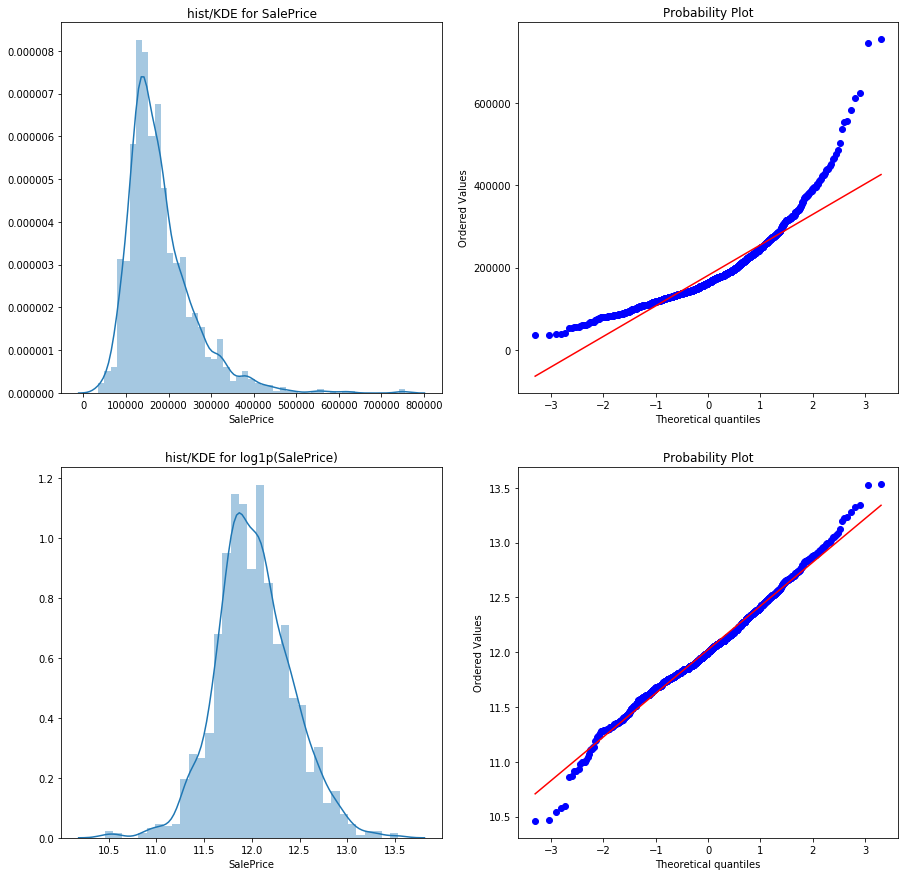

In [37]:
fig, axs = plt.subplots(nrows=2,ncols=2);
fig.set_size_inches(15,15);

# hist/KDE for SalePrice
sns.distplot(ytrain, ax=axs[0][0]);
axs[0][0].set_title('hist/KDE for SalePrice');

# QQ-plot
res = stats.probplot(ytrain, plot=axs[0][1]);

# hist/KDE for ln(1+SalePrice)
sns.distplot(np.log1p(ytrain), ax=axs[1][0]);
axs[1][0].set_title("hist/KDE for log1p(SalePrice)");

# QQ-plot for ln(1+SalePrice)
res = stats.probplot(np.log1p(ytrain), plot=axs[1][1]);

The dependent variable SalePrice has moderate positive skew. I'm going to try logging it in the transformations section below.

### Manual outlier detection with scatterplots

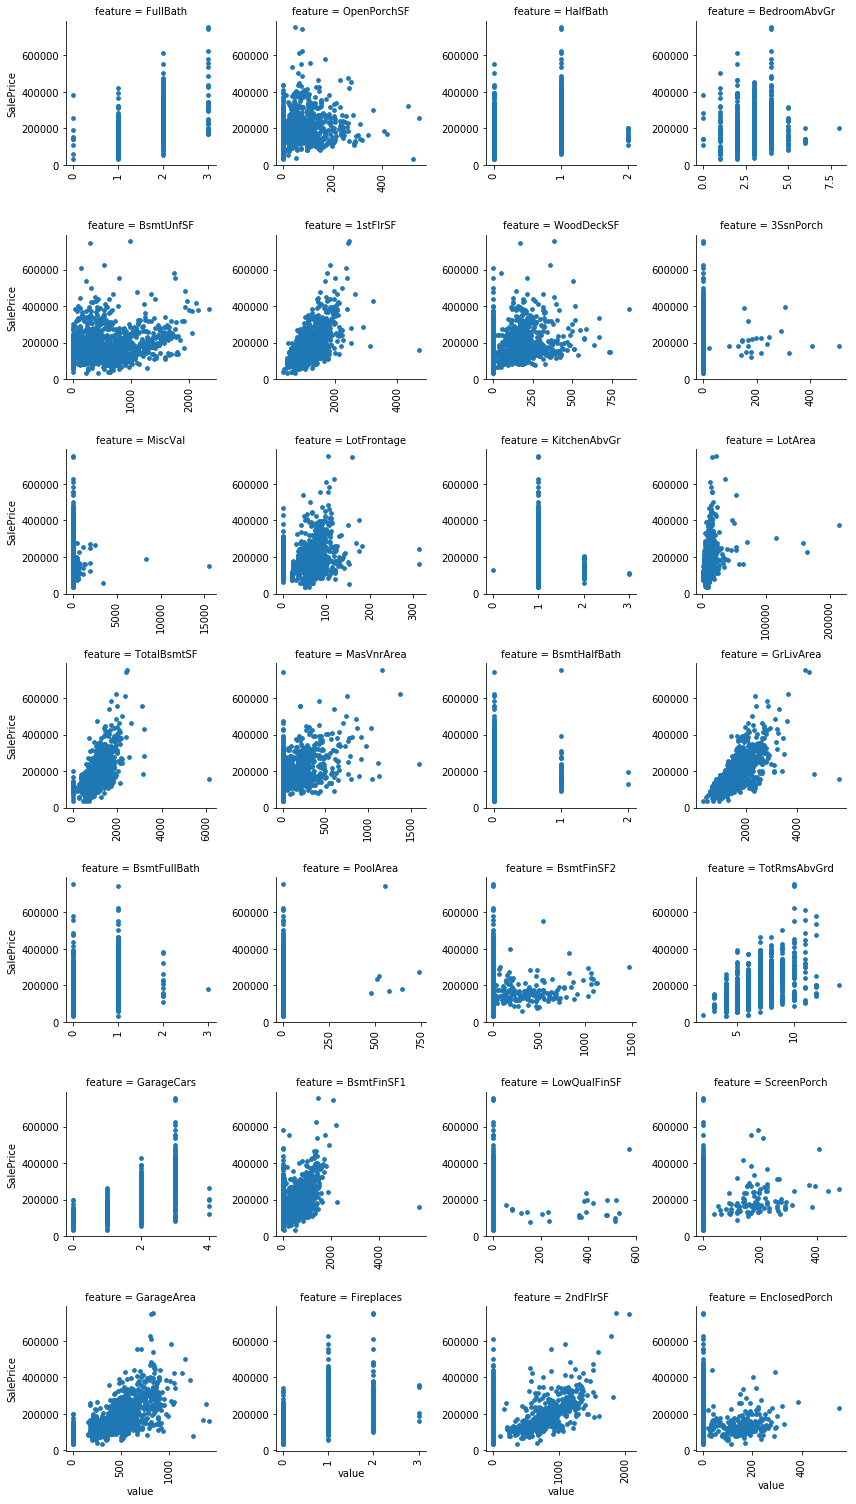

In [38]:
# generate the box plots (nice use of melt/FacetGrid adobted from Dominik GawlikHouse)
def scatter(x, y, **kwargs):
    plt.scatter(x=x, y=y, s=14)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative_features, var_name='feature')
g = sns.FacetGrid(f, col="feature",  col_wrap=4, sharex=False, sharey=False, size=3)
g = g.map(scatter, "value", "SalePrice")

### Mean absolute deviation (MAD) of quantitative features as a way to rank presence of potential outliers

In [39]:
Xtrain[quantitative_features].mad().sort_values(ascending=False)

LotArea          3758.813815
GrLivArea         397.324938
2ndFlrSF          396.477549
BsmtFinSF1        367.369673
BsmtUnfSF         353.281616
TotalBsmtSF       321.284373
1stFlrSF          300.576309
GarageArea        160.019065
MasVnrArea        129.435711
WoodDeckSF        101.995795
MiscVal            83.880233
BsmtFinSF2         82.535014
OpenPorchSF        47.678078
EnclosedPorch      37.659525
ScreenPorch        27.728670
LotFrontage        26.085541
LowQualFinSF       11.480880
3SsnPorch           6.707082
PoolArea            5.491353
TotRmsAbvGrd        1.279595
GarageCars          0.583843
Fireplaces          0.579424
BedroomAbvGr        0.576309
FullBath            0.522439
BsmtFullBath        0.498758
HalfBath            0.478858
BsmtHalfBath        0.108606
KitchenAbvGr        0.090246
dtype: float64

**Comments:** It looks like there exists a few very large houses in the training data that appear as outliers. Points that have high leverage may cause problems, such as the two points in GrLivArea with extreme x values, but moderately small y values.

For now, rather than exclude these outliers, I'll try out robust methods of regression. Later on I'll try removing high leverage points. 

**update:** After creating a couple estimators, I'll now try dropping the two high leverage points to see if my model improves.

Xtrain number of rows: 1460
Xtrain number of rows: 1458


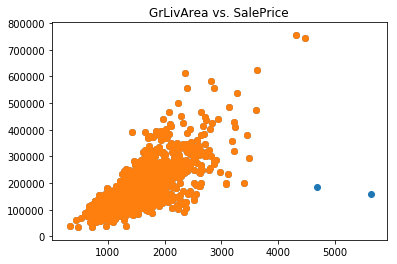

In [40]:
plt.scatter(Xtrain.GrLivArea, ytrain);
plt.title("GrLivArea vs. SalePrice")
print("Xtrain number of rows:", Xtrain.shape[0]);

drop_points = Xtrain.GrLivArea.sort_values(ascending=False)[:2].index.values.tolist();
Xtrain.drop(drop_points, inplace=True);
ytrain.drop(drop_points, inplace=True);
plt.scatter(Xtrain.GrLivArea, ytrain);
print("Xtrain number of rows:", Xtrain.shape[0]);

### Checking feature multicollinearity with heatmaps

#### Linear relationships

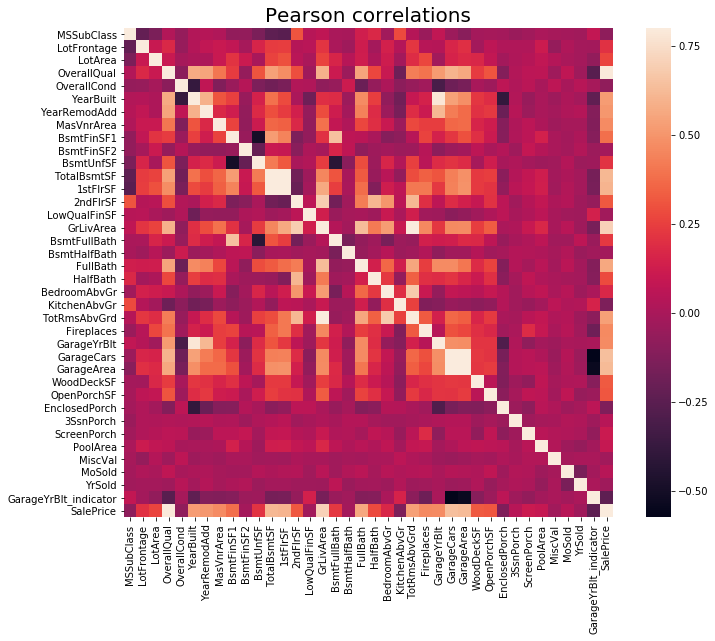

In [42]:
# linear relationships
pearson_corrmat = train.corr(method="pearson")

# Full Pearson correlation matrix
f, ax = plt.subplots(figsize=(12, 9));
sns.heatmap(pearson_corrmat, vmax=.8, square=True);
ax.set_title('Pearson correlations', FontSize=20);

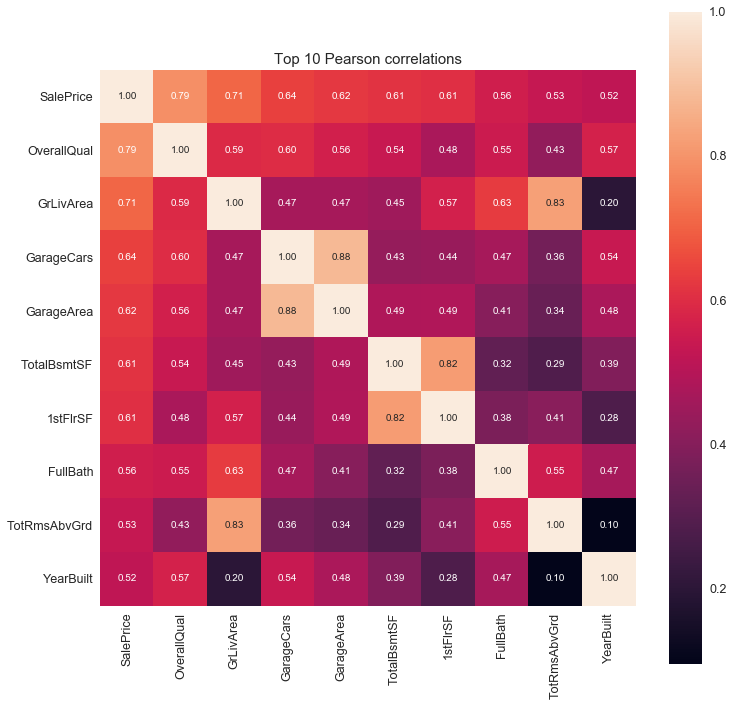

In [43]:
# Top Pearson correlations matrix with labeled values
k = 10
fig = plt.figure(figsize=(12,12));
cols = pearson_corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Top %d Pearson correlations' %k);

#### Monotonic relationships

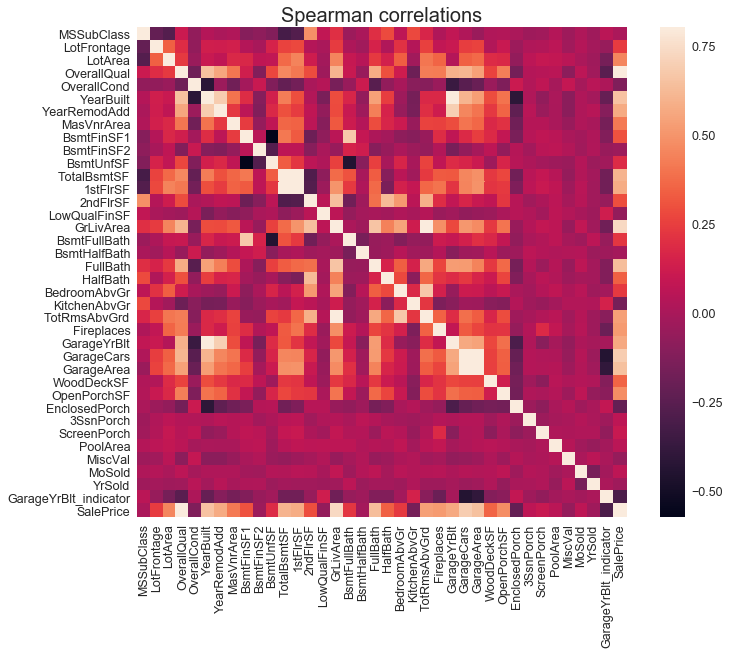

In [44]:
# monotonic relationships
spearman_corrmat = train.corr(method="spearman")

# Full Spearman correlation matrix
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(spearman_corrmat, vmax=.8, square=True);
ax.set_title('Spearman correlations', FontSize=20);

**Comments: ** There are some highly correlated feature pairs for which the model might benefit from their removal.

- GarageArea and GarageCars
- TotalBsmtSF and 1stFlrSf

For now I'll leave these feature pairs and perform standardization to reduce multicollinearity. After building estimators I'll check if accuracy improves by removing one of each pair.

["...standardizing the independent variables is a simple method to reduce multicollinearity that is produced by higher-order terms. Although, it’s important to note that it won’t work for other causes of multicollinearity."](http://statisticsbyjim.com/regression/standardize-variables-regression/)


## Transforming Features

#### log the dependent variable

In [45]:
transformTarget = True
if transformTarget:
    ytrain = np.log1p(ytrain)

### Create custom mappings for ordinal string features

In [46]:
print('len(ordinal_string_cols):', len(ordinal_string_cols), '\n\n')

for f in ordinal_string_cols:
    print('\n', f, '\n\n', Xtrain[f].value_counts(), '\n\n','-'*35)

len(ordinal_string_cols): 18 



 BsmtCond 

 TA    1309
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64 

 -----------------------------------

 BsmtExposure 

 No    953
Av    221
Gd    132
Mn    114
NA     38
Name: BsmtExposure, dtype: int64 

 -----------------------------------

 BsmtFinType1 

 Unf    430
GLQ    416
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: BsmtFinType1, dtype: int64 

 -----------------------------------

 BsmtFinType2 

 Unf    1254
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64 

 -----------------------------------

 BsmtQual 

 TA    649
Gd    618
Ex    119
NA     37
Fa     35
Name: BsmtQual, dtype: int64 

 -----------------------------------

 Electrical 

 SBrkr    1333
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64 

 -----------------------------------

 ExterCond 

 TA    1280
Gd     146
Fa      28
Ex       3
Po 

In [47]:
# need a list of dictionaries, one for each ordinal string mapping

# each mapping:

# PoolQC
NA_Fa_TA_Gd_Ex = {"NA":"0", "Fa":"1", "TA":"2", "Gd":"3", "Ex":"4"}

# Fence
NA_MnWw_GdWo_MnPrv_GdPrv = {"NA":"0", "MnWw":"1", "GdWo":"2", "MnPrv":"3", "GdPrv":"4"}

# Exter Cond, Exter Qual, Heating QC, Kitchen Qual
Po_Fa_TA_Gd_Ex = {"Po":"0", "Fa":"1", "TA":"2", "Gd":"3", "Ex":"4"}

# Bsmt Cond, Bsmt Qual, Garage Cond, Garage Qual, FireplaceQu
NA_Po_Fa_TA_Gd_Ex = {"NA":"0", "Po":"1", "Fa":"2", "TA":"3", "Gd":"4", "Ex":"5"}

# Bsmt Exposure
NA_No_Mn_Av_Gd = {"NA":"0", "No":"1", "Mn":"2", "Av":"3", "Gd":"4"}

# BsmtFin Type 1, BsmtFin Type 2
NA_Unf_LwQ_Rec_BLQ_ALQ_GLQ = {"NA":"0", "Unf":"1", "LwQ":"2", "Rec":"3", "BLQ":"4", "ALQ":"5", "GLQ":"6"}
# Electrical
Mix_FuseP_FuseF_FuseA_SBrkr = {"Mix":"0", "FuseP":"1", "FuseF":"2", "FuseA":"3", "SBrkr":"4"}

# Functional
Sal_Sev_Maj2_Maj1_Mod_Min2_Min1_Typ = {"Sal":"0", "Sev":"1", "Maj2":"2", "Maj1":"3", "Mod":"4", 
                                       "Min2":"5", "Min1":"6", "Typ":"7"}

# Garage Finish
NA_Unf_RFn_Fin = {"NA":"0", "Unf":"1", "RFn":"2", "Fin":"3"}

# Land Slope
Sev_Mod_Gtl = {"Sev":"0", "Mod":"1", "Gtl":"2"}

# Paved Drive
N_P_Y = {"N":"0", "P":"1", "Y":"2"}

# Utilities
ELO_NoSeWa_NoSewr_AllPub = {"ELO":"0", "NoSeWa":"1", "NoSewr":"2", "AllPub":"3"}

# dict of mapping dicts
mappings = {
    "ExterCond":Po_Fa_TA_Gd_Ex,
    "ExterQual":Po_Fa_TA_Gd_Ex,
    "HeatingQC":Po_Fa_TA_Gd_Ex,
    "KitchenQual":Po_Fa_TA_Gd_Ex,
    "BsmtCond":NA_Po_Fa_TA_Gd_Ex,
    "BsmtQual":NA_Po_Fa_TA_Gd_Ex,
    "GarageCond":NA_Po_Fa_TA_Gd_Ex,
    "GarageQual":NA_Po_Fa_TA_Gd_Ex,
    "BsmtExposure":NA_No_Mn_Av_Gd,
    "BsmtFinType1":NA_Unf_LwQ_Rec_BLQ_ALQ_GLQ,
    "BsmtFinType2":NA_Unf_LwQ_Rec_BLQ_ALQ_GLQ,
    "Electrical":Mix_FuseP_FuseF_FuseA_SBrkr,
    "Functional":Sal_Sev_Maj2_Maj1_Mod_Min2_Min1_Typ,
    "GarageFinish":NA_Unf_RFn_Fin,
    "LandSlope":Sev_Mod_Gtl,
    "PavedDrive":N_P_Y,
    "Utilities":ELO_NoSeWa_NoSewr_AllPub,
    "PoolQC":NA_Fa_TA_Gd_Ex,
    "FireplaceQu":NA_Po_Fa_TA_Gd_Ex,
    "Fence":NA_MnWw_GdWo_MnPrv_GdPrv
}

In [48]:
# remove drop_features from mappings
print("number of mappings before removing drop_features:", len(list(mappings.keys())))
mappings = {key: mappings[key] for key in mappings if key not in drop_features}
print("number of mappings after removing drop_features:", len(list(mappings.keys())))

number of mappings before removing drop_features: 20
number of mappings after removing drop_features: 18


In [49]:
# Convert each categorical type so that when I create dummy columns the two data sets stay the same size
for c in cat_cols_all:
    possible_categories = sorted(list(set(Xtrain[c].unique().tolist() + Xtest[c].unique().tolist())))
    Xtrain[c] = Xtrain[c].astype('category', categories=possible_categories)
    Xtest[c] = Xtest[c].astype('category', categories=possible_categories)

/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead

/Users/austin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



In [50]:
Xtrain.isnull().sum().sum()

0

### Feature transformation class for Xtrain and Xtest

In [51]:
class TransformData(TransformerMixin):
    
    def __init__(self):
        """Going to try and add:
        - map ordinal string features to floats
        - convert catNum, catStr to dummy cols
        - check types
        - log transforms
        - standardization
        """
        
    def fit(self, mappings={}, contNum=[], discNum=[], ordNum=[], catNum=[], ordStr=[], catStr=[],
            transform_quant_ivs=[]):
        
        self.mappings = mappings
        self.contNum = contNum
        self.discNum = discNum
        self.ordNum = ordNum
        self.catNum = catNum
        self.ordStr = ordStr
        self.catStr = catStr
        
        return self

    def transform(self, X):
        
        # copy df
        Xcopy = X.copy()
        # print original shape
        print('\noriginal shape: ', Xcopy.shape)  
        
        # map ordinal string features to floats
        for f in self.mappings.keys():
            Xcopy[f] = Xcopy[f].replace(self.mappings[f]).astype('float64')   
        
        # convert catNum, catStr to dummy columns   
        # use N-1 columns to get rid of baseline variable and avoid collinearity
        dummy_cols = pd.get_dummies(Xcopy[self.catNum+self.catStr], drop_first=True).astype('float64')    
        Xcopy.drop(self.catNum+self.catStr, axis=1, inplace=True)
        Xcopy = pd.concat([Xcopy, dummy_cols], axis=1)
        print("shape after dummy columns added: ", Xcopy.shape)   
        
        # make sure types are all what I want
        num_cols = Xcopy.select_dtypes(['uint8', 'int', 'float']).columns
        str_cols = Xcopy.select_dtypes(['object']).columns  
        if (len(num_cols)+len(str_cols) == Xcopy.shape[1]):
            Xcopy[num_cols] = Xcopy[num_cols].astype('float64')
        
        # Check that all features are now float64
        float64_cols = list(Xcopy.select_dtypes(['float64']).columns)
        print("All features now float64?: ", len(float64_cols) == Xcopy.shape[1])    
        if not len(float64_cols) == Xcopy.shape[1]:
            print(len(float64_cols))
            print(Xcopy.shape[1])
            nonfloat_cols = list(set(Xcopy.columns.tolist()) - set(float64_cols))
            print(nonfloat_cols)        
        
       # list of binary features
        binary_features = Xcopy.columns[(Xcopy.max()<=1) & (Xcopy.min()>=0)].tolist()
        len(binary_features)
    
        # list on non-binary features
        nonbinary_features = list(set(Xcopy.columns.tolist()) - set(binary_features))     
    
        # Log transformation of select quantitative predictors
        Xcopy[transform_quant_ivs] = np.log1p(Xcopy[transform_quant_ivs])        
        
        # Standardization
        # https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso
        standardizeAll = False
        standardizeNonBinary = True

        # Standardizing the dummies also so that they aren't outweighed by the continuous variables
        # RobustScaler shows a very slight performance advantage over StandardScaler on chosen estimators
        if standardizeAll:
            Xcopy = pd.DataFrame(StandardScaler().fit_transform(Xcopy), columns = Xcopy.columns.tolist())
        elif standardizeNonBinary: 
#            Xcopy = pd.DataFrame(StandardScaler().fit_transform(Xcopy), columns = nonbinary_features)
            Xcopy[nonbinary_features] = StandardScaler().fit_transform(Xcopy[nonbinary_features])

        return Xcopy

### Create transformer object, fit and transform Xtrain and Xtest, check that columns are the same

In [52]:
# create transformer obkect
transformer = TransformData();

# fit transformer
transformer.fit(mappings, contin_num_cols, discrete_num_cols, ordinal_num_cols, 
                        categorical_num_cols, ordinal_string_cols, categorical_string_cols, transform_quant_ivs);

# transform Xtrain and Xtest
Xtrain = transformer.transform(Xtrain);
Xtest = transformer.transform(Xtest);

# check heads
Xtrain.head()
Xtest.head()

# Check that the same exact dummy columns were created
print("\nSame columns in Xtrain and Xtest? ", Xtrain.columns.tolist() == Xtest.columns.tolist());


Xtrain.isnull().sum().sum()


original shape:  (1458, 74)
shape after dummy columns added:  (1458, 204)
All features now float64?:  True

original shape:  (1459, 74)
shape after dummy columns added:  (1459, 204)
All features now float64?:  True


LotFrontage   LotArea  LandSlope  OverallQual  OverallCond  YearBuilt  \
0     0.223761 -0.129624   0.225879     0.658506    -0.517649   1.052959   
1     0.665308  0.118819   0.225879    -0.068293     2.177825   0.158428   
2     0.312070  0.427643   0.225879     0.658506    -0.517649   0.986698   
3     0.076579  0.108651   0.225879     0.658506    -0.517649  -1.862551   
4     0.783053  0.889295   0.225879     1.385305    -0.517649   0.953567   

   YearRemodAdd  MasVnrArea  ExterQual  ExterCond        ...         \
0      0.880362    1.207635   1.061109  -0.238285        ...          
1     -0.428115   -0.805570  -0.689001  -0.238285        ...          
2      0.831900    1.135442   1.061109  -0.238285        ...          
3     -0.718888   -0.805570  -0.689001  -0.238285        ...          
4      0.734975    1.427727   1.061109  -0.238285        ...          

   Condition1_Norm  Condition1_PosA  Condition1_PosN  Condition1_RRAe  \
0              1.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              1.0              0.0              0.0              0.0   
3              1.0              0.0              0.0              0.0   
4              1.0              0.0              0.0              0.0   

   Condition1_RRAn  Condition1_RRNe  Condition1_RRNn  MasVnrType_BrkFace  \
0              0.0              0.0              0.0                 1.0   
1              0.0              0.0              0.0                 0.0   
2              0.0              0.0              0.0                 1.0   
3              0.0              0.0              0.0                 0.0   
4              0.0              0.0              0.0                 1.0   

   MasVnrType_None  MasVnrType_Stone  
0              0.0               0.0  
1              1.0               0.0  
2              0.0               0.0  
3              1.0               0.0  
4              0.0               0.0  

[5 rows x 204 columns]

LotFrontage   LotArea  LandSlope  OverallQual  OverallCond  YearBuilt  \
0     0.684849  0.561787   0.207992    -0.751101     0.400766  -0.340945   
1     0.715852  0.970407   0.207992    -0.054877     0.400766  -0.439695   
2     0.498831  0.908413   0.207992    -0.751101    -0.497418   0.844059   
3     0.622843  0.257857   0.207992    -0.054877     0.400766   0.876976   
4    -0.462261 -1.116969   0.207992     1.337571    -0.497418   0.679475   

   YearRemodAdd  MasVnrArea  ExterQual  ExterCond        ...         \
0     -1.072885   -0.780195  -0.678102  -0.223518        ...          
1     -1.214908    1.015602  -0.678102  -0.223518        ...          
2      0.678742   -0.780195  -0.678102  -0.223518        ...          
3      0.678742    0.385215  -0.678102  -0.223518        ...          
4      0.394694   -0.780195   1.027675  -0.223518        ...          

   Condition1_Norm  Condition1_PosA  Condition1_PosN  Condition1_RRAe  \
0              0.0              0.0              0.0              0.0   
1              1.0              0.0              0.0              0.0   
2              1.0              0.0              0.0              0.0   
3              1.0              0.0              0.0              0.0   
4              1.0              0.0              0.0              0.0   

   Condition1_RRAn  Condition1_RRNe  Condition1_RRNn  MasVnrType_BrkFace  \
0              0.0              0.0              0.0                 0.0   
1              0.0              0.0              0.0                 1.0   
2              0.0              0.0              0.0                 0.0   
3              0.0              0.0              0.0                 1.0   
4              0.0              0.0              0.0                 0.0   

   MasVnrType_None  MasVnrType_Stone  
0              1.0               0.0  
1              0.0               0.0  
2              1.0               0.0  
3              0.0               0.0  
4              1.0               0.0  

[5 rows x 204 columns]


Same columns in Xtrain and Xtest?  True


0

# <center><font color='blue'>BUILDING MODELS</font></center>


### Goals:
- [Nested cross-validation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html), [more notes on nested cross-validation](https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection)
    - outer `cross_val_score()` for unbiased performance estimation
    - inner `GridSearchCV()` for hyperparameter optimization (model selection)
    - [details/graphic](https://sebastianraschka.com/faq/docs/evaluate-a-model.html):
<img src="img/nested cross-validation.png" style="width:50%" align="middle">  
    - possibly use: half-half split for model selection, and leave-one-out for model performance evaluation ([paper](http://file.scirp.org/pdf/OJS_2015080511003128.pdf))
    - can also try 5x2 cross-validation 

- dictionary of models
- dictionary of parameters to optimize for each model
- custom scoring function (RMSE-log)

- **Pipelines**
    - What can I pipeline?
    
- **Use KFold with shuffle=True**
    - within cross_val_score() and cross_val_predict()
    
- **Strategy:**
    - cross_val_score(GridSearchCV()) to find best estimators
    - GridsearchCV on best estimators to find best parameters
    - Fit best estimators/parameters on entire training set
    - Predict best fitted estimators/parameters on test set
<br>

- **Residuals plots:**
    - Fitted (predicted) value on X, residual value on Y
    - random pattern in residuals plot indicates good fit for linear model (should be no discernible pattern)
    - Also do a predicted vs. actual value plot with line        
    - QQ-plot of residuals
        - Since we are concerned about the normality of the error terms, we create a [normal probability plot of the residuals](https://onlinecourses.science.psu.edu/stat501/node/281). If the resulting plot is approximately linear, we proceed assuming that the error terms are normally distributed.
    - Note that the relationship between the theoretical percentiles and the sample percentiles is approximately linear. Therefore, the normal probability plot of the residuals suggests that the error terms are indeed normally distributed.
<br>    

- **Obtain std of cross-validated RMSE's:** 
    - to see how stable the model is (ex. 12k std is very unstable)  
<br>    

- **Implement stacking:**
    - [Top 4% tutorial](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
    - [A Kaggler's Guide to Model Stacking in Practice](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)
    - [mlxtend StackingCVRegressor](https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/)
    - [Ensemble of different kinds of regressors using scikit-learn](https://stackoverflow.com/questions/28727709/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho/35170149#35170149)  
<br>   

- **Implement Model Averaging:**
    - "Stacking did not give us the intended results, although it improved our score slightly and did put us in the top 20% of participants. We therefore decided to use model averaging. This is a simple strategy where you average out your predictions. Below is a simple visual representation. Seeing as this approach gave us significantly better results, we decided to include even more models into the averaging, placing more weight on the models we know performed well."
<br>    


### Estimators to try:

These are the estimators I'm going to try (for now at least):

- [sklearn.linear_model.Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [sklearn.kernel_ridge.KernelRidge](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)*
- [sklearn.linear_model.Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)*
- [sklearn.linear_model.ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)*
- [sklearn.svm.LinearSVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)
- [sklearn.svm.SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [sklearn.ensemble.AdaBoostRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)*
- [sklearn.ensemble.RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)*
- [sklearn.ensemble.BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)
- [sklearn.ensemble.ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)*
- [sklearn.ensemble.GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)* (with huber loss for outliers)
- [xgboost.XGBRegressor](http://xgboost.readthedocs.io/en/latest/python/python_api.html)*
- [lightgbm.LGBMRegressor](http://lightgbm.readthedocs.io/en/latest/python/lightgbm.html)*

### [Some notes on GLMs](http://scikit-learn.org/stable/modules/linear_model.html#lasso)

For each of these, I'll want to use `GridSearchCV` to tune any hyperparameter(s) that the estimators may have. I'll take a look at the documentation for each of them and create a dictionary of parameter ranges to optimize. 




Order:

- GridSearchCV for best parameters for each individual model
    - put into dict
    - try half/half & leave-one-out, 5-2
    - check std of cv scores

- detour: check residual plots 
- KFold with shuffle=True




### Custom scoring function according to competition metric (RMSE of ln(prices))

In [54]:
def custom_scorer(actual, predicted):    
    actual = np.log1p(actual)
    predicted = np.log1p(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

log_rmse_scorer = make_scorer(custom_scorer, greater_is_better=False)
log_rmse_scorer

make_scorer(custom_scorer, greater_is_better=False)

#### KFold cross-validators

In [55]:
cv2 = KFold(n_splits=2, random_state=42, shuffle=True)
cv3 = KFold(n_splits=3, random_state=42, shuffle=True)
cv5 = KFold(n_splits=5, random_state=42, shuffle=True)
cv10 = KFold(n_splits=10, random_state=42, shuffle=True)

# Feature Selection via Recursive Feature Elimination with cross-validation

In [58]:
print("Number of features :", Xtrain.shape[1])

# Create the RFE object and compute a cross-validated score.
lasso_cv = LassoCV(cv=cv5, random_state=42, max_iter=2500);
#lasso = gsCV_lasso.best_estimator_
rfecv = RFECV(estimator=lasso_cv, step=1, cv=cv3, scoring='neg_mean_squared_log_error',verbose=0)
rfecv.fit(Xtrain, ytrain)

Number of features : 204


RFECV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
   estimator=LassoCV(alphas=None, copy_X=True,
    cv=KFold(n_splits=5, random_state=42, shuffle=True), eps=0.001,
    fit_intercept=True, max_iter=2500, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=42,
    selection='cyclic', tol=0.0001, verbose=False),
   n_jobs=1, scoring='neg_mean_squared_log_error', step=1, verbose=0)

## Interactive RFECV Plot with Plotly

In [62]:
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

cf.set_config_file(offline=True, theme='ggplot')

init_notebook_mode(connected=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [63]:
print("Optimal number of features : %d" % rfecv.n_features_)

trace = go.Scatter(x=list(range(1, len(rfecv.grid_scores_) + 1)), 
                   y=rfecv.grid_scores_)

layout = go.Layout(xaxis=dict(title="Number of features selected",
                              showgrid=False),
                   yaxis=dict(title="Cross validation score (nb of correct classifications)",
                              showgrid=False)
                  )

fig = go.Figure(data=[trace], layout=layout)

iplot(fig)

Optimal number of features : 155


# END TESTING

In [48]:
# drop 10 worst features
Xtrain_drop_worst = Xtrain.drop(worst_ten_features, axis=1)
Xtrain_drop_worst.shape[1]

# drop all but best 38 features (rank 1's)
Xtrain_top_features = Xtrain.drop(list(set(Xtrain.columns.tolist())-set(best_features)), axis=1)
Xtrain_top_features.shape[1]

Xtrain_versions = [Xtrain, Xtrain_drop_worst, Xtrain_top_features]
Xtrain_descriptions = ["Xtrain", "Xtrain_drop_worst", "Xtrain_top_features"]

194

33

In [49]:
scores = [];
lasso_cv = LassoCV(n_jobs=-1, cv=cv5, random_state=42);

for i, X_v in enumerate(Xtrain_versions):   
    X_v.name = Xtrain_descriptions[i];
    lasso_cv.fit(X_v,ytrain);
    ypred = cross_val_predict(lasso_cv, X_v, ytrain, cv=cv5);
    scores.append(custom_scorer(np.expm1(ytrain),np.expm1(ypred)));
    #print('Custom scorer (RMSE(ln()):', scores[i])

print("Best Xtrain dataframe version:", Xtrain_versions[scores.index(min(scores))].name);
Xtrain_Best = Xtrain_versions[scores.index(min(scores))];

Best Xtrain dataframe version: Xtrain_top_features


In [50]:
# Set Xtrain and Xtest to post-feature-selected versions
Xtrain = Xtrain_Best
Xtest = Xtest[Xtrain_Best.columns.tolist()]

## Base Models

### Ridge Regression

In [51]:
ridge = Ridge(random_state=42)
ridge_params = {'alpha': list(np.logspace(-4,0,100))}
gsCV_ridge = GridSearchCV(estimator=ridge, param_grid=ridge_params, cv=cv5, n_jobs=-1, scoring=log_rmse_scorer)
gsCV_ridge.fit(Xtrain,ytrain)
print(gsCV_ridge.best_estimator_)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.00010974987654930556, 0.00012045035402587823, 0.00013219411484660288, 0.00014508287784959401, 0.00015922827933410923, 0.00017475284000076829, 0.00019179102616724886, 0.00021049041445120198, 0.00023101297000831605, 0.00025353644939701115, 0.00027825594022071258, 0.0003...418342592, 0.68926121043497024, 0.75646332755462908, 0.83021756813197523, 0.91116275611548958, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_scorer, greater_is_better=False),
       verbose=0)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)


In [52]:
ridge = gsCV_ridge.best_estimator_

ypred = cross_val_predict(ridge, Xtrain, ytrain, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(ridge,Xtrain,ytrain,cv=cv5,n_jobs=-1)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

Custom scorer (RMSE(ln()): 0.107541496967
CV Score (R^2): 0.926795991459


#### Examining the Residuals for this model

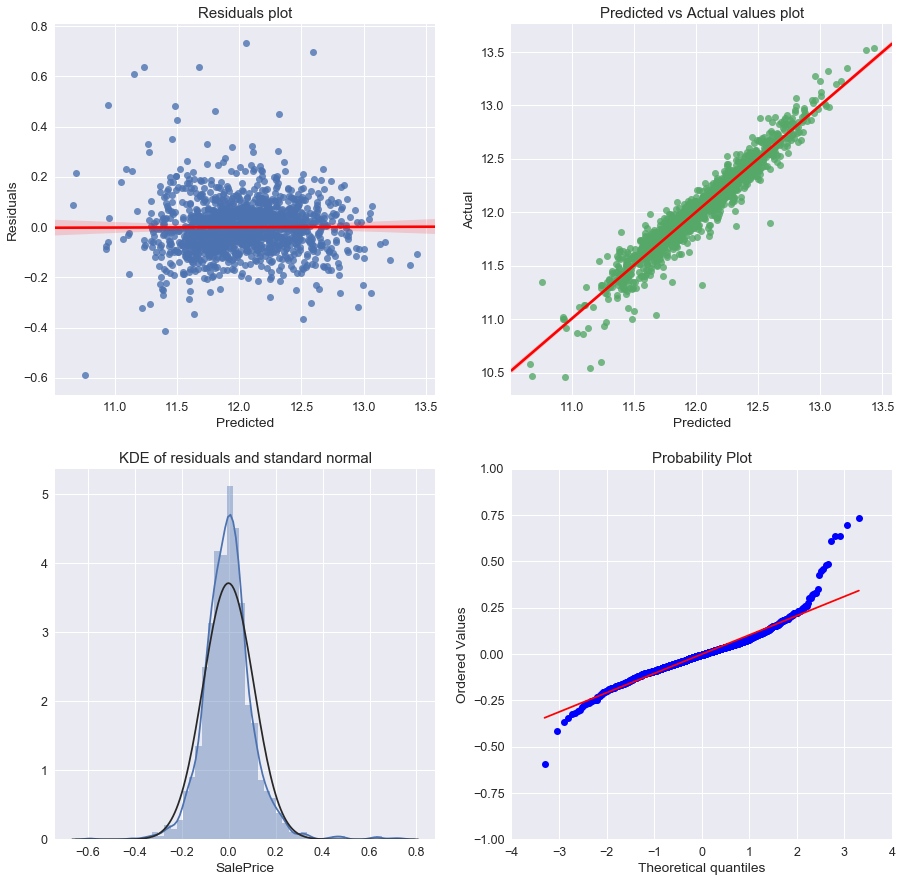

In [53]:
residuals = ypred - ytrain

fig, axes = plt.subplots(2,2)
fig.set_size_inches(15,15)

# residual plot
axes[0][0].set_title("Residuals plot")
sns.regplot(ypred,residuals, line_kws={'color': 'red'}, ax=axes[0][0]);
axes[0][0].set_xlabel('Predicted')
axes[0][0].set_ylabel('Residuals')

# predicted vs actual plot
axes[0][1].set_title("Predicted vs Actual values plot")
sns.regplot(ypred,ytrain, line_kws={'color': 'red'}, ax=axes[0][1]);
axes[0][1].set_xlabel('Predicted')
axes[0][1].set_ylabel('Actual')

# gaussian KDE plot of residuals and standard normal distribution overlaid
axes[1][0].set_title("KDE of residuals and standard normal")
sns.distplot(residuals, fit=stats.norm, ax=axes[1][0]);

# QQ-plot of residuals
axes[1][1].set_xlim((-4,4))
axes[1][1].set_ylim((-1,1))
res = stats.probplot(residuals, plot=axes[1][1]);

note: can copy and paste above code block below other models for residuals evaluation

**Comments:**

The residual plot of predicted vs residual values should ideally show no discernible pattern. A random pattern indicates a good fit for the linear model. My plot looks symetrically distributed, clustered at the center with no clear pattern, which is a good sign. The y-axis is slightly unbalanced, but besides that the residuals appear to look good. There doesn't appear to be any indication of heteroscedasticity, nonlinearity, or non-additivity in this plot, so those regression assumptions were likely not violated. 

The predicted versus actual values plot seems to fit well to a 45 degree regression line. On the lower end for cheaper houses, the model seems to underestimate sale price.

If the QQ-plot were approximately linear I could assume that the error terms are normally distributed, however, this is not the case. The normality of error assumption appears to be violated due to fat tails. This is an indication that there are too many residuals that are too far from the predicted line. This means kurtosis (sometimes "peakedness") is too large, which appears to be the case in the first plot as well. As the goal here is prediction rather than inference, this is not a key assumption.

### Kernel Ridge Regression

In [54]:
kernelridge = KernelRidge()
kernelridge_params = {'alpha': list(np.logspace(-4,0,100)), 'kernel':['polynomial', 'rbf'], 'degree':[2,3]}
gsCV_kernelridge = GridSearchCV(estimator=kernelridge, param_grid=kernelridge_params, cv=cv5, n_jobs=-1, scoring=log_rmse_scorer, verbose=2)
gsCV_kernelridge.fit(Xtrain,ytrain)
print(gsCV_kernelridge.best_estimator_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] alpha=0.0001, degree=2, kernel=polynomial .......................
[CV] alpha=0.0001, degree=2, kernel=polynomial .......................
[CV] alpha=0.0001, degree=2, kernel=polynomial .......................
[CV] alpha=0.0001, degree=2, kernel=polynomial .......................
[CV] alpha=0.0001, degree=2, kernel=polynomial .......................
[CV] alpha=0.0001, degree=2, kernel=rbf ..............................
[CV] alpha=0.0001, degree=2, kernel=rbf ..............................
[CV] alpha=0.0001, degree=2, kernel=rbf ..............................
[CV] ........ alpha=0.0001, degree=2, kernel=polynomial, total=   0.3s
[CV] alpha=0.0001, degree=2, kernel=rbf ..............................
[CV] ........ alpha=0.0001, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0001, degree=2, kernel=rbf ..............................
[CV] ........ alpha=0.0001, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s


[CV]  alpha=0.000109749876549, degree=3, kernel=polynomial, total=   0.6s
[CV]  alpha=0.000109749876549, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000109749876549, degree=3, kernel=rbf ...................
[CV] alpha=0.000109749876549, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000109749876549, degree=3, kernel=rbf, total=   0.3s
[CV] alpha=0.000120450354026, degree=2, kernel=polynomial ............
[CV] .... alpha=0.000109749876549, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.000120450354026, degree=2, kernel=polynomial ............
[CV]  alpha=0.000109749876549, degree=3, kernel=polynomial, total=   0.5s
[CV] .... alpha=0.000109749876549, degree=3, kernel=rbf, total=   0.4s
[CV]  alpha=0.000109749876549, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000120450354026, degree=2, kernel=polynomial ............
[CV] alpha=0.000120450354026, degree=2, kernel=polynomial ............
[CV] alpha=0.000120450354026, degree=2, kernel=polynomial .......

[CV] ..... alpha=0.00014508287785, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00014508287785, degree=3, kernel=rbf ....................
[CV] alpha=0.00014508287785, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00014508287785, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00014508287785, degree=3, kernel=rbf ....................
[CV]  alpha=0.00014508287785, degree=3, kernel=polynomial, total=   0.3s
[CV]  alpha=0.00014508287785, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.00014508287785, degree=3, kernel=rbf ....................
[CV]  alpha=0.00014508287785, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.00014508287785, degree=3, kernel=rbf ....................
[CV] alpha=0.000159228279334, degree=2, kernel=polynomial ............
[CV]  alpha=0.00014508287785, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.000159228279334, degree=2, kernel=polynomial ............
[CV]  alpha=0.00014508287785, degree=3, kernel=polynomial, total=   0

[CV] .... alpha=0.000191791026167, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000191791026167, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000191791026167, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000191791026167, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000191791026167, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000191791026167, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000191791026167, degree=2, kernel=rbf, total=   0.5s


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.3s


[CV] alpha=0.000191791026167, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000191791026167, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000191791026167, degree=3, kernel=rbf ...................
[CV]  alpha=0.000191791026167, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.000191791026167, degree=3, kernel=rbf ...................
[CV]  alpha=0.000191791026167, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.000191791026167, degree=3, kernel=rbf ...................
[CV]  alpha=0.000191791026167, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.000210490414451, degree=2, kernel=polynomial ............
[CV] .... alpha=0.000191791026167, degree=3, kernel=rbf, total=   0.5s
[CV]  alpha=0.000210490414451, degree=2, kernel=polynomial, total=   0.3s
[CV] .... alpha=0.000191791026167, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.000210490414451, degree=2, kernel=polynomial ............
[CV] alpha=0.000210490414451, degree=2, kernel=polynomial .......

[CV] .... alpha=0.000253536449397, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.000253536449397, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000253536449397, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.000253536449397, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000253536449397, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000253536449397, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000253536449397, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000253536449397, degree=3, kernel=rbf ...................
[CV]  alpha=0.000253536449397, degree=3, kernel=polynomial, total=   0.4s
[CV]  alpha=0.000253536449397, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000253536449397, degree=3, kernel=rbf ...................
[CV]  alpha=0.000253536449397, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.000253536449397, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000253536449397, degree=3, kernel=rbf, total=   0.

[CV] alpha=0.000335160265094, degree=3, kernel=polynomial ............
[CV]  alpha=0.000335160265094, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.000335160265094, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000335160265094, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000335160265094, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000335160265094, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000335160265094, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000335160265094, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000335160265094, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000335160265094, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000335160265094, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000335160265094, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000335160265094, degree=3, kernel=rbf ...................
[CV]  alpha=0.000335160265094, degree=3, kernel=polynomial, total=   0.5s


[CV] alpha=0.000443062145758, degree=2, kernel=rbf ...................
[CV] alpha=0.000443062145758, degree=2, kernel=rbf ...................
[CV]  alpha=0.000443062145758, degree=2, kernel=polynomial, total=   0.4s
[CV]  alpha=0.000443062145758, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.000443062145758, degree=3, kernel=polynomial ............
[CV] alpha=0.000443062145758, degree=3, kernel=polynomial ............
[CV]  alpha=0.000443062145758, degree=2, kernel=polynomial, total=   0.3s
[CV] alpha=0.000443062145758, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000443062145758, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000443062145758, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000443062145758, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000443062145758, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000443062145758, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000443062145758, degree=3, kernel=rbf .................

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.3s


[CV]  alpha=0.000486260158007, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000486260158007, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000486260158007, degree=3, kernel=rbf, total=   0.4s
[CV]  alpha=0.000486260158007, degree=3, kernel=polynomial, total=   0.5s
[CV]  alpha=0.000486260158007, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000486260158007, degree=3, kernel=rbf ...................
[CV]  alpha=0.000486260158007, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000533669923121, degree=2, kernel=polynomial ............
[CV] alpha=0.000533669923121, degree=2, kernel=polynomial ............
[CV] alpha=0.000533669923121, degree=2, kernel=polynomial ............
[CV] .... alpha=0.000486260158007, degree=3, kernel=rbf, total=   0.4s
[CV]  alpha=0.000486260158007, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.000533669923121, degree=2, kernel=polynomial ............
[CV] .... alpha=0.000486260158007, degree=3, kernel=rbf, total

[CV] alpha=0.000642807311728, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000642807311728, degree=2, kernel=rbf, total=   0.7s
[CV] .... alpha=0.000642807311728, degree=2, kernel=rbf, total=   0.6s
[CV] .... alpha=0.000642807311728, degree=2, kernel=rbf, total=   0.6s
[CV] alpha=0.000642807311728, degree=3, kernel=rbf ...................
[CV] alpha=0.000642807311728, degree=3, kernel=rbf ...................
[CV] alpha=0.000642807311728, degree=3, kernel=rbf ...................
[CV]  alpha=0.000642807311728, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000642807311728, degree=3, kernel=rbf ...................
[CV]  alpha=0.000642807311728, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000705480231072, degree=2, kernel=polynomial ............
[CV]  alpha=0.000642807311728, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.000705480231072, degree=2, kernel=polynomial ............
[CV]  alpha=0.000705480231072, degree=2, kernel=polynomial, total=  

[CV] .... alpha=0.000849753435909, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.000849753435909, degree=3, kernel=polynomial ............
[CV] .... alpha=0.000849753435909, degree=2, kernel=rbf, total=   0.5s
[CV] .... alpha=0.000849753435909, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000849753435909, degree=3, kernel=polynomial ............
[CV] alpha=0.000849753435909, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000849753435909, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000849753435909, degree=3, kernel=rbf ...................
[CV] .... alpha=0.000849753435909, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.000849753435909, degree=3, kernel=rbf ...................
[CV]  alpha=0.000849753435909, degree=3, kernel=polynomial, total=   0.6s
[CV] alpha=0.000849753435909, degree=3, kernel=rbf ...................
[CV]  alpha=0.000849753435909, degree=3, kernel=polynomial, total=   0.6s
[CV]  alpha=0.000849753435909, degree=3, kernel=polynomial, total=   0.

[CV]  alpha=0.00112332403298, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.00112332403298, degree=3, kernel=polynomial .............
[CV] alpha=0.00112332403298, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00112332403298, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.00112332403298, degree=3, kernel=polynomial .............
[CV]  alpha=0.00112332403298, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.00112332403298, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00112332403298, degree=2, kernel=rbf, total=   0.5s
[CV] ..... alpha=0.00112332403298, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.00112332403298, degree=3, kernel=polynomial .............
[CV] alpha=0.00112332403298, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00112332403298, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00112332403298, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00112332403298, degree=2, kernel=rbf, total=   0.6s
[C

[CV] ..... alpha=0.00135304777458, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.00148496826225, degree=2, kernel=rbf ....................
[CV] ..... alpha=0.00135304777458, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.00148496826225, degree=2, kernel=rbf ....................
[CV]  alpha=0.00148496826225, degree=2, kernel=polynomial, total=   0.6s
[CV] alpha=0.00148496826225, degree=3, kernel=polynomial .............
[CV]  alpha=0.00148496826225, degree=2, kernel=polynomial, total=   0.6s
[CV] alpha=0.00148496826225, degree=3, kernel=polynomial .............
[CV]  alpha=0.00148496826225, degree=2, kernel=polynomial, total=   0.6s
[CV] alpha=0.00148496826225, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00148496826225, degree=2, kernel=rbf, total=   0.6s
[CV] alpha=0.00148496826225, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00148496826225, degree=2, kernel=rbf, total=   0.6s
[CV] alpha=0.00148496826225, degree=3, kernel=polynomial .............


[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   43.7s


[CV]  alpha=0.00178864952906, degree=3, kernel=polynomial, total=   0.3s
[CV] alpha=0.00196304065004, degree=2, kernel=polynomial .............
[CV] ..... alpha=0.00178864952906, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.00196304065004, degree=2, kernel=polynomial .............
[CV]  alpha=0.00196304065004, degree=2, kernel=polynomial, total=   0.3s
[CV] alpha=0.00196304065004, degree=2, kernel=polynomial .............
[CV] ..... alpha=0.00178864952906, degree=3, kernel=rbf, total=   0.4s
[CV] ..... alpha=0.00178864952906, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.00196304065004, degree=2, kernel=polynomial .............
[CV]  alpha=0.00178864952906, degree=3, kernel=polynomial, total=   0.5s
[CV] ..... alpha=0.00178864952906, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.00196304065004, degree=2, kernel=rbf ....................
[CV] alpha=0.00196304065004, degree=2, kernel=rbf ....................
[CV] alpha=0.00196304065004, degree=2, kernel=rbf ....................


[CV] alpha=0.00236448941265, degree=3, kernel=rbf ....................
[CV]  alpha=0.00236448941265, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.00236448941265, degree=3, kernel=rbf ....................
[CV]  alpha=0.00236448941265, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.0025950242114, degree=2, kernel=polynomial ..............
[CV]  alpha=0.00236448941265, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.0025950242114, degree=2, kernel=polynomial ..............
[CV] ..... alpha=0.00236448941265, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.0025950242114, degree=2, kernel=polynomial ..............
[CV] ..... alpha=0.00236448941265, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.0025950242114, degree=2, kernel=polynomial ..............
[CV]  alpha=0.00236448941265, degree=3, kernel=polynomial, total=   0.6s
[CV] ..... alpha=0.00236448941265, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.0025950242114, degree=2, kernel=polynomial .............

[CV] alpha=0.00312571584969, degree=3, kernel=rbf ....................
[CV] alpha=0.00312571584969, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00312571584969, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.00312571584969, degree=3, kernel=rbf ....................
[CV]  alpha=0.00312571584969, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.00312571584969, degree=3, kernel=rbf ....................
[CV]  alpha=0.00312571584969, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.00312571584969, degree=3, kernel=rbf ....................
[CV]  alpha=0.00312571584969, degree=3, kernel=polynomial, total=   0.6s
[CV] alpha=0.00343046928631, degree=2, kernel=polynomial .............
[CV] ..... alpha=0.00312571584969, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.00343046928631, degree=2, kernel=polynomial .............
[CV]  alpha=0.00312571584969, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.00343046928631, degree=2, kernel=polynomial ............

[CV] alpha=0.00413201240012, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00413201240012, degree=2, kernel=rbf, total=   0.5s
[CV] ..... alpha=0.00413201240012, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00413201240012, degree=3, kernel=polynomial .............
[CV] alpha=0.00413201240012, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00413201240012, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00413201240012, degree=3, kernel=rbf ....................
[CV]  alpha=0.00413201240012, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.00413201240012, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00413201240012, degree=2, kernel=rbf, total=   0.6s
[CV] alpha=0.00413201240012, degree=3, kernel=rbf ....................
[CV]  alpha=0.00413201240012, degree=3, kernel=polynomial, total=   0.4s
[CV]  alpha=0.00413201240012, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.00413201240012, degree=3, kernel=rbf ....................


[CV] ..... alpha=0.00497702356433, degree=3, kernel=rbf, total=   0.7s
[CV] alpha=0.00546227721768, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00546227721768, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.00546227721768, degree=3, kernel=polynomial .............
[CV]  alpha=0.00546227721768, degree=2, kernel=polynomial, total=   0.6s
[CV] alpha=0.00546227721768, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00546227721768, degree=2, kernel=rbf, total=   0.6s
[CV] alpha=0.00546227721768, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00546227721768, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00546227721768, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00546227721768, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00546227721768, degree=3, kernel=rbf ....................
[CV] ..... alpha=0.00546227721768, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.00546227721768, degree=3, kernel=rbf ....................
[CV]

[CV]  alpha=0.00722080901839, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.00722080901839, degree=2, kernel=rbf ....................
[CV]  alpha=0.00722080901839, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.00722080901839, degree=2, kernel=rbf ....................
[CV] alpha=0.00722080901839, degree=2, kernel=rbf ....................
[CV] alpha=0.00722080901839, degree=3, kernel=polynomial .............
[CV] alpha=0.00722080901839, degree=3, kernel=polynomial .............
[CV]  alpha=0.00722080901839, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.00722080901839, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00722080901839, degree=2, kernel=rbf, total=   0.6s
[CV] alpha=0.00722080901839, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00722080901839, degree=2, kernel=rbf, total=   0.6s
[CV] alpha=0.00722080901839, degree=3, kernel=polynomial .............
[CV] ..... alpha=0.00722080901839, degree=2, kernel=rbf, total=   0.4s


[CV] alpha=0.00954548456662, degree=2, kernel=rbf ....................
[CV] alpha=0.00954548456662, degree=2, kernel=rbf ....................
[CV] ..... alpha=0.00869749002618, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.00954548456662, degree=2, kernel=rbf ....................
[CV]  alpha=0.00954548456662, degree=2, kernel=polynomial, total=   0.3s
[CV]  alpha=0.00954548456662, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.00954548456662, degree=2, kernel=rbf ....................
[CV] alpha=0.00954548456662, degree=2, kernel=rbf ....................
[CV]  alpha=0.00954548456662, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.00954548456662, degree=3, kernel=polynomial .............
[CV]  alpha=0.00954548456662, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.00954548456662, degree=3, kernel=polynomial .............
[CV]  alpha=0.00954548456662, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.00954548456662, degree=3, kernel=polynomial ..........

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.1min


[CV]  alpha=0.0104761575279, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0104761575279, degree=2, kernel=rbf .....................
[CV]  alpha=0.0104761575279, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0104761575279, degree=2, kernel=rbf .....................
[CV] ..... alpha=0.00954548456662, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.0104761575279, degree=3, kernel=polynomial ..............
[CV]  alpha=0.0104761575279, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0104761575279, degree=3, kernel=polynomial ..............
[CV]  alpha=0.0104761575279, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0104761575279, degree=3, kernel=polynomial ..............
[CV] ...... alpha=0.0104761575279, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.0104761575279, degree=3, kernel=polynomial ..............
[CV] ...... alpha=0.0104761575279, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.0104761575279, degree=3, kernel=polynomial ..............
[C

[CV]  alpha=0.0138488637139, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0138488637139, degree=2, kernel=rbf .....................
[CV]  alpha=0.0138488637139, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0138488637139, degree=2, kernel=rbf .....................
[CV] ...... alpha=0.0126185688307, degree=3, kernel=rbf, total=   0.5s
[CV] ...... alpha=0.0126185688307, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.0138488637139, degree=2, kernel=rbf .....................
[CV] alpha=0.0138488637139, degree=2, kernel=rbf .....................
[CV]  alpha=0.0138488637139, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0138488637139, degree=3, kernel=polynomial ..............
[CV]  alpha=0.0138488637139, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0138488637139, degree=3, kernel=polynomial ..............
[CV]  alpha=0.0138488637139, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.0138488637139, degree=3, kernel=polynomial ..............
[

[CV] alpha=0.018307382803, degree=2, kernel=polynomial ...............
[CV] alpha=0.018307382803, degree=2, kernel=polynomial ...............
[CV] ....... alpha=0.016681005372, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.018307382803, degree=2, kernel=rbf ......................
[CV] ....... alpha=0.016681005372, degree=3, kernel=rbf, total=   0.5s
[CV]  alpha=0.018307382803, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.018307382803, degree=2, kernel=rbf ......................
[CV] alpha=0.018307382803, degree=2, kernel=rbf ......................
[CV] ....... alpha=0.016681005372, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.018307382803, degree=2, kernel=rbf ......................
[CV]  alpha=0.018307382803, degree=2, kernel=polynomial, total=   0.5s
[CV]  alpha=0.018307382803, degree=2, kernel=polynomial, total=   0.3s
[CV] alpha=0.018307382803, degree=2, kernel=rbf ......................
[CV] alpha=0.018307382803, degree=3, kernel=polynomial ...............
[CV]  

[CV]  alpha=0.0242012826479, degree=2, kernel=polynomial, total=   0.3s
[CV] ....... alpha=0.022051307399, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.0242012826479, degree=2, kernel=polynomial ..............
[CV] alpha=0.0242012826479, degree=2, kernel=polynomial ..............
[CV] ....... alpha=0.022051307399, degree=3, kernel=rbf, total=   0.5s
[CV] ....... alpha=0.022051307399, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.0242012826479, degree=2, kernel=polynomial ..............
[CV] alpha=0.0242012826479, degree=2, kernel=rbf .....................
[CV] ....... alpha=0.022051307399, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.0242012826479, degree=2, kernel=rbf .....................
[CV] ....... alpha=0.022051307399, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.0242012826479, degree=2, kernel=rbf .....................
[CV]  alpha=0.022051307399, degree=3, kernel=polynomial, total=   0.6s
[CV] alpha=0.0242012826479, degree=2, kernel=rbf .....................
[CV] 

[CV] alpha=0.0291505306283, degree=3, kernel=rbf .....................
[CV]  alpha=0.0291505306283, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.031992671378, degree=2, kernel=polynomial ...............
[CV] alpha=0.031992671378, degree=2, kernel=polynomial ...............
[CV]  alpha=0.0291505306283, degree=3, kernel=polynomial, total=   0.6s
[CV] alpha=0.031992671378, degree=2, kernel=polynomial ...............
[CV]  alpha=0.0291505306283, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.031992671378, degree=2, kernel=polynomial ...............
[CV] ...... alpha=0.0291505306283, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.031992671378, degree=2, kernel=polynomial ...............
[CV]  alpha=0.0291505306283, degree=3, kernel=polynomial, total=   0.7s
[CV] alpha=0.031992671378, degree=2, kernel=rbf ......................
[CV]  alpha=0.031992671378, degree=2, kernel=polynomial, total=   0.3s
[CV]  alpha=0.031992671378, degree=2, kernel=polynomial, total=   0.5s
[C

[CV] alpha=0.0385352859371, degree=3, kernel=rbf .....................
[CV] alpha=0.0385352859371, degree=3, kernel=rbf .....................
[CV]  alpha=0.0385352859371, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.0385352859371, degree=3, kernel=rbf .....................
[CV]  alpha=0.0385352859371, degree=3, kernel=polynomial, total=   0.6s
[CV] alpha=0.0422924287439, degree=2, kernel=polynomial ..............
[CV]  alpha=0.0385352859371, degree=3, kernel=polynomial, total=   0.6s
[CV] alpha=0.0422924287439, degree=2, kernel=polynomial ..............
[CV] ...... alpha=0.0385352859371, degree=3, kernel=rbf, total=   0.3s
[CV] alpha=0.0422924287439, degree=2, kernel=polynomial ..............
[CV] ...... alpha=0.0385352859371, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.0422924287439, degree=2, kernel=polynomial ..............
[CV]  alpha=0.0422924287439, degree=2, kernel=polynomial, total=   0.3s
[CV] alpha=0.0422924287439, degree=2, kernel=polynomial ..............
[C

[CV] ...... alpha=0.0509413801482, degree=2, kernel=rbf, total=   0.4s
[CV] ...... alpha=0.0509413801482, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.0509413801482, degree=3, kernel=rbf .....................
[CV] alpha=0.0509413801482, degree=3, kernel=rbf .....................
[CV] alpha=0.0509413801482, degree=3, kernel=rbf .....................
[CV]  alpha=0.0509413801482, degree=3, kernel=polynomial, total=   0.3s
[CV]  alpha=0.0509413801482, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.0509413801482, degree=3, kernel=rbf .....................
[CV] alpha=0.0509413801482, degree=3, kernel=rbf .....................
[CV]  alpha=0.0509413801482, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.0559081018251, degree=2, kernel=polynomial ..............
[CV]  alpha=0.0509413801482, degree=3, kernel=polynomial, total=   0.3s
[CV] alpha=0.0559081018251, degree=2, kernel=polynomial ..............
[CV] ...... alpha=0.0509413801482, degree=3, kernel=rbf, total=   0.3s
[C

[CV] ...... alpha=0.0673415065775, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.0673415065775, degree=3, kernel=polynomial ..............
[CV] ...... alpha=0.0673415065775, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.0673415065775, degree=3, kernel=polynomial ..............
[CV] ...... alpha=0.0673415065775, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.0673415065775, degree=3, kernel=rbf .....................
[CV] ...... alpha=0.0673415065775, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.0673415065775, degree=3, kernel=rbf .....................
[CV] ...... alpha=0.0673415065775, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.0673415065775, degree=3, kernel=rbf .....................
[CV]  alpha=0.0673415065775, degree=3, kernel=polynomial, total=   0.5s
[CV]  alpha=0.0673415065775, degree=3, kernel=polynomial, total=   0.5s
[CV]  alpha=0.0673415065775, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.0673415065775, degree=3, kernel=rbf .....................
[CV

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.6min


[CV] ....... alpha=0.081113083079, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.081113083079, degree=3, kernel=rbf ......................
[CV]  alpha=0.081113083079, degree=3, kernel=polynomial, total=   0.3s
[CV] alpha=0.081113083079, degree=3, kernel=rbf ......................
[CV]  alpha=0.081113083079, degree=3, kernel=polynomial, total=   0.5s
[CV] ....... alpha=0.081113083079, degree=2, kernel=rbf, total=   0.5s
[CV] ....... alpha=0.081113083079, degree=3, kernel=rbf, total=   0.3s
[CV] alpha=0.081113083079, degree=3, kernel=rbf ......................
[CV]  alpha=0.081113083079, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.081113083079, degree=3, kernel=rbf ......................
[CV] alpha=0.0890215085445, degree=2, kernel=polynomial ..............
[CV] alpha=0.0890215085445, degree=2, kernel=polynomial ..............
[CV]  alpha=0.081113083079, degree=3, kernel=polynomial, total=   0.6s
[CV] alpha=0.0890215085445, degree=2, kernel=polynomial ..............
[CV]  

[CV] ....... alpha=0.107226722201, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.107226722201, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.107226722201, degree=2, kernel=rbf, total=   0.4s
[CV] ....... alpha=0.107226722201, degree=2, kernel=rbf, total=   0.4s
[CV] ....... alpha=0.107226722201, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.107226722201, degree=3, kernel=rbf ......................
[CV] alpha=0.107226722201, degree=3, kernel=rbf ......................
[CV]  alpha=0.107226722201, degree=3, kernel=polynomial, total=   0.3s
[CV] alpha=0.107226722201, degree=3, kernel=rbf ......................
[CV]  alpha=0.107226722201, degree=3, kernel=polynomial, total=   0.3s
[CV] alpha=0.107226722201, degree=3, kernel=rbf ......................
[CV] alpha=0.107226722201, degree=3, kernel=rbf ......................
[CV]  alpha=0.107226722201, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=0.117681195243, degree=2, kernel=polynomial ...............
[CV] .

[CV]  alpha=0.141747416293, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.141747416293, degree=3, kernel=polynomial ...............
[CV]  alpha=0.141747416293, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.141747416293, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.141747416293, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.141747416293, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.141747416293, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.141747416293, degree=3, kernel=rbf ......................
[CV] ....... alpha=0.141747416293, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.141747416293, degree=3, kernel=rbf ......................
[CV] ....... alpha=0.141747416293, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.141747416293, degree=3, kernel=rbf ......................
[CV]  alpha=0.141747416293, degree=3, kernel=polynomial, total=   0.4s
[CV]  alpha=0.141747416293, degree=3, kernel=polynomial, total=   0.4s
[CV] a

[CV] ....... alpha=0.170735264747, degree=3, kernel=rbf, total=   0.5s
[CV]  alpha=0.187381742286, degree=2, kernel=polynomial, total=   0.3s
[CV] alpha=0.187381742286, degree=3, kernel=polynomial ...............
[CV] alpha=0.187381742286, degree=3, kernel=polynomial ...............
[CV]  alpha=0.187381742286, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.187381742286, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.187381742286, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.187381742286, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.187381742286, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.187381742286, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.187381742286, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.187381742286, degree=3, kernel=rbf ......................
[CV] ....... alpha=0.187381742286, degree=2, kernel=rbf, total=   0.4s
[CV] alpha=0.187381742286, degree=3, kernel=rbf ......................
[CV] .

[CV]  alpha=0.247707635599, degree=2, kernel=polynomial, total=   0.6s
[CV] alpha=0.247707635599, degree=2, kernel=rbf ......................
[CV]  alpha=0.247707635599, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.247707635599, degree=2, kernel=rbf ......................
[CV]  alpha=0.247707635599, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.247707635599, degree=3, kernel=polynomial ...............
[CV]  alpha=0.247707635599, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.247707635599, degree=3, kernel=polynomial ...............
[CV]  alpha=0.247707635599, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.247707635599, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.247707635599, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.247707635599, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.247707635599, degree=2, kernel=rbf, total=   0.4s
[CV] ....... alpha=0.247707635599, degree=2, kernel=rbf, total=   0.3s
[CV] a

[CV] alpha=0.327454916288, degree=2, kernel=rbf ......................
[CV] alpha=0.327454916288, degree=2, kernel=rbf ......................
[CV] ....... alpha=0.298364724028, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.327454916288, degree=2, kernel=rbf ......................
[CV]  alpha=0.327454916288, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.327454916288, degree=2, kernel=rbf ......................
[CV]  alpha=0.327454916288, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.327454916288, degree=2, kernel=rbf ......................
[CV]  alpha=0.327454916288, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.327454916288, degree=3, kernel=polynomial ...............
[CV] ....... alpha=0.327454916288, degree=2, kernel=rbf, total=   0.3s
[CV] ....... alpha=0.327454916288, degree=2, kernel=rbf, total=   0.3s
[CV] alpha=0.327454916288, degree=3, kernel=polynomial ...............
[CV] alpha=0.327454916288, degree=3, kernel=polynomial ...............
[CV]  

[CV] ....... alpha=0.394420605944, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.432876128108, degree=2, kernel=polynomial ...............
[CV] ....... alpha=0.394420605944, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.432876128108, degree=2, kernel=rbf ......................
[CV]  alpha=0.432876128108, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.432876128108, degree=2, kernel=rbf ......................
[CV] ....... alpha=0.394420605944, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.432876128108, degree=2, kernel=rbf ......................
[CV] ....... alpha=0.394420605944, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.432876128108, degree=2, kernel=rbf ......................
[CV]  alpha=0.432876128108, degree=2, kernel=polynomial, total=   0.5s
[CV]  alpha=0.432876128108, degree=2, kernel=polynomial, total=   0.5s
[CV] alpha=0.432876128108, degree=2, kernel=rbf ......................
[CV] alpha=0.432876128108, degree=3, kernel=polynomial ...............
[CV]  

[CV] alpha=0.572236765935, degree=2, kernel=polynomial ...............
[CV] alpha=0.572236765935, degree=2, kernel=polynomial ...............
[CV] ......... alpha=0.5214008288, degree=3, kernel=rbf, total=   0.3s
[CV] alpha=0.572236765935, degree=2, kernel=polynomial ...............
[CV] ......... alpha=0.5214008288, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.572236765935, degree=2, kernel=polynomial ...............
[CV] ......... alpha=0.5214008288, degree=3, kernel=rbf, total=   0.6s
[CV] alpha=0.572236765935, degree=2, kernel=rbf ......................
[CV] ......... alpha=0.5214008288, degree=3, kernel=rbf, total=   0.5s
[CV] alpha=0.572236765935, degree=2, kernel=rbf ......................
[CV]  alpha=0.572236765935, degree=2, kernel=polynomial, total=   0.6s
[CV] alpha=0.572236765935, degree=2, kernel=rbf ......................
[CV]  alpha=0.572236765935, degree=2, kernel=polynomial, total=   0.5s
[CV]  alpha=0.572236765935, degree=2, kernel=polynomial, total=   0.5s
[CV] a

[CV] alpha=0.689261210435, degree=3, kernel=rbf ......................
[CV] alpha=0.689261210435, degree=3, kernel=rbf ......................
[CV] alpha=0.756463327555, degree=2, kernel=polynomial ...............
[CV] alpha=0.756463327555, degree=2, kernel=polynomial ...............
[CV]  alpha=0.689261210435, degree=3, kernel=polynomial, total=   0.3s
[CV] alpha=0.756463327555, degree=2, kernel=polynomial ...............
[CV]  alpha=0.756463327555, degree=2, kernel=polynomial, total=   0.3s
[CV] alpha=0.756463327555, degree=2, kernel=polynomial ...............
[CV] ....... alpha=0.689261210435, degree=3, kernel=rbf, total=   0.4s
[CV]  alpha=0.756463327555, degree=2, kernel=polynomial, total=   0.4s
[CV] alpha=0.756463327555, degree=2, kernel=polynomial ...............
[CV] alpha=0.756463327555, degree=2, kernel=rbf ......................
[CV] ....... alpha=0.689261210435, degree=3, kernel=rbf, total=   0.4s
[CV] alpha=0.756463327555, degree=2, kernel=rbf ......................
[CV]  

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.2min


[CV] ....... alpha=0.911162756115, degree=2, kernel=rbf, total=   0.5s
[CV] alpha=0.911162756115, degree=3, kernel=rbf ......................
[CV]  alpha=0.911162756115, degree=3, kernel=polynomial, total=   0.5s
[CV]  alpha=0.911162756115, degree=3, kernel=polynomial, total=   0.5s
[CV]  alpha=0.911162756115, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.911162756115, degree=3, kernel=rbf ......................
[CV]  alpha=0.911162756115, degree=3, kernel=polynomial, total=   0.5s
[CV] alpha=0.911162756115, degree=3, kernel=rbf ......................
[CV] alpha=1.0, degree=2, kernel=polynomial ..........................
[CV] alpha=1.0, degree=2, kernel=polynomial ..........................
[CV] ....... alpha=0.911162756115, degree=3, kernel=rbf, total=   0.3s
[CV] alpha=1.0, degree=2, kernel=polynomial ..........................
[CV]  alpha=0.911162756115, degree=3, kernel=polynomial, total=   0.4s
[CV] alpha=1.0, degree=2, kernel=polynomial ..........................
[CV] .

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.00010974987654930556, 0.00012045035402587823, 0.00013219411484660288, 0.00014508287784959401, 0.00015922827933410923, 0.00017475284000076829, 0.00019179102616724886, 0.00021049041445120198, 0.00023101297000831605, 0.00025353644939701115, 0.00027825594022071258, 0.0003..., 0.83021756813197523, 0.91116275611548958, 1.0], 'kernel': ['polynomial', 'rbf'], 'degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_scorer, greater_is_better=False),
       verbose=2)

KernelRidge(alpha=1.0, coef0=1, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None)


In [55]:
kernelridge = gsCV_kernelridge.best_estimator_

ypred = cross_val_predict(kernelridge, Xtrain, ytrain, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(kernelridge,Xtrain,ytrain,cv=cv5,n_jobs=-1)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

Custom scorer (RMSE(ln()): 0.117497788721
CV Score (R^2): 0.913135894927


### LASSO Regression

In [56]:
lasso = Lasso(random_state=42)
lasso_params = {'alpha': list(np.logspace(-4,0,100))}
gsCV_lasso = GridSearchCV(estimator=lasso, param_grid=lasso_params, cv=cv5, n_jobs=-1, scoring=log_rmse_scorer)
gsCV_lasso.fit(Xtrain,ytrain)
print(gsCV_lasso.best_estimator_)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.00010974987654930556, 0.00012045035402587823, 0.00013219411484660288, 0.00014508287784959401, 0.00015922827933410923, 0.00017475284000076829, 0.00019179102616724886, 0.00021049041445120198, 0.00023101297000831605, 0.00025353644939701115, 0.00027825594022071258, 0.0003...418342592, 0.68926121043497024, 0.75646332755462908, 0.83021756813197523, 0.91116275611548958, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_scorer, greater_is_better=False),
       verbose=0)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)


In [57]:
lasso = gsCV_lasso.best_estimator_

ypred = cross_val_predict(lasso, Xtrain, ytrain, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(lasso,Xtrain,ytrain,cv=cv5,n_jobs=-1)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

Custom scorer (RMSE(ln()): 0.107605590339
CV Score (R^2): 0.926712552616


##### Fitting to train, predicting on test, and outputting submission file:

In [58]:
lasso = gsCV_lasso.best_estimator_
lasso.fit(Xtrain,ytrain)
predictions = lasso.predict(Xtest)
predictions = np.expm1(predictions)

output_df = pd.DataFrame()
output_df['Id'] = IDtest
output_df['SalePrice'] = predictions

output_df.head()
output_df.to_csv('/Users/austin/Desktop/outputs/lasso_output.csv', index=False)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

Id      SalePrice
0  1461  128210.338853
1  1462  162906.850283
2  1463  189409.230364
3  1464  204756.300518
4  1465  199282.344043

### ElasticNet Regression

In [59]:
elasticnet = ElasticNet(random_state=42)
elasticnet_params = {'alpha': list(np.logspace(-4,0,100)), 'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 
                     'normalize':[False],'max_iter':[8000]}
gsCV_elasticnet = GridSearchCV(estimator=elasticnet, param_grid=elasticnet_params, cv=cv2, n_jobs=-1, scoring=log_rmse_scorer)
gsCV_elasticnet.fit(Xtrain,ytrain)
print(gsCV_elasticnet.best_estimator_)

GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.00010974987654930556, 0.00012045035402587823, 0.00013219411484660288, 0.00014508287784959401, 0.00015922827933410923, 0.00017475284000076829, 0.00019179102616724886, 0.00021049041445120198, 0.00023101297000831605, 0.00025353644939701115, 0.00027825594022071258, 0.0003...'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'normalize': [False], 'max_iter': [8000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_scorer, greater_is_better=False),
       verbose=0)

ElasticNet(alpha=0.00048626015800653534, copy_X=True, fit_intercept=True,
      l1_ratio=0.1, max_iter=8000, normalize=False, positive=False,
      precompute=False, random_state=42, selection='cyclic', tol=0.0001,
      warm_start=False)


In [60]:
elasticnet = gsCV_elasticnet.best_estimator_

ypred = cross_val_predict(elasticnet, Xtrain, ytrain, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(elasticnet,Xtrain,ytrain,cv=cv5,n_jobs=-1)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

Custom scorer (RMSE(ln()): 0.107571455015
CV Score (R^2): 0.926756968914


### Random Forest Regression

In [61]:
# Running GridSearchCV
# 'max_features': [50,100,140,160,'auto']
# 'max_features': [int(i) for i in list(np.linspace(int(Xtrain.shape[1]/5),Xtrain.shape[1],5).round())]
# [7, 15, 22, 30, 38]
randomforest = RandomForestRegressor(n_jobs=-1, random_state=42) 
randomforest_params = {'max_depth': [None,10,20,30,40,50,60,70], 'n_estimators': [250,500,1000], 
                       'max_features': [int(i) for i in list(np.linspace(int(Xtrain.shape[1]/10),
                                                                         Xtrain.shape[1],10).round())]}
gsCV_randomforest = GridSearchCV(estimator=randomforest, param_grid=randomforest_params, cv=cv2, 
                                 n_jobs=-1, verbose=1, scoring=log_rmse_scorer) 

gsCV_randomforest.fit(Xtrain,ytrain)
print(gsCV_randomforest.best_estimator_)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.0min finished


GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [None, 10, 20, 30, 40, 50, 60, 70], 'n_estimators': [250, 500, 1000], 'max_features': [3, 6, 10, 13, 16, 20, 23, 26, 30, 33]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_scorer, greater_is_better=False),
       verbose=1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


In [62]:
randomforest = gsCV_randomforest.best_estimator_

ypred = cross_val_predict(randomforest, Xtrain, ytrain, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(randomforest,Xtrain,ytrain,cv=cv5,n_jobs=-1)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

Custom scorer (RMSE(ln()): 0.131026128293
CV Score (R^2): 0.892129605454


### Gradient Boosting Regression

In [63]:
gradientboost = GradientBoostingRegressor(random_state=42)
gradientboost_params = {'loss':['huber'], 'max_depth': [None,3,10,20,30,40,50,60,70], 'n_estimators': [250,500,1000], 
                        'max_features': [int(i) for i in list(np.linspace(int(Xtrain.shape[1]/5),Xtrain.shape[1],5).round())]} 
gsCV_gradientboost = GridSearchCV(estimator=gradientboost, param_grid=gradientboost_params, cv=cv2, 
                                  n_jobs=-1, verbose=2, scoring=log_rmse_scorer)
gsCV_gradientboost.fit(Xtrain,ytrain)
print(gsCV_gradientboost.best_estimator_)

Fitting 2 folds for each of 135 candidates, totalling 270 fits
[CV] loss=huber, max_depth=None, max_features=6, n_estimators=250 ....
[CV] loss=huber, max_depth=None, max_features=6, n_estimators=250 ....
[CV] loss=huber, max_depth=None, max_features=6, n_estimators=500 ....
[CV] loss=huber, max_depth=None, max_features=6, n_estimators=500 ....
[CV] loss=huber, max_depth=None, max_features=6, n_estimators=1000 ...
[CV] loss=huber, max_depth=None, max_features=6, n_estimators=1000 ...
[CV] loss=huber, max_depth=None, max_features=13, n_estimators=250 ...
[CV] loss=huber, max_depth=None, max_features=13, n_estimators=250 ...
[CV]  loss=huber, max_depth=None, max_features=13, n_estimators=250, total=   5.2s
[CV] loss=huber, max_depth=None, max_features=13, n_estimators=500 ...
[CV]  loss=huber, max_depth=None, max_features=13, n_estimators=250, total=   5.3s
[CV] loss=huber, max_depth=None, max_features=13, n_estimators=500 ...
[CV]  loss=huber, max_depth=None, max_features=6, n_estimator

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.7s


[CV]  loss=huber, max_depth=3, max_features=6, n_estimators=500, total=   1.3s
[CV] loss=huber, max_depth=3, max_features=6, n_estimators=1000 ......
[CV]  loss=huber, max_depth=3, max_features=6, n_estimators=500, total=   1.2s
[CV] loss=huber, max_depth=3, max_features=6, n_estimators=1000 ......
[CV]  loss=huber, max_depth=3, max_features=6, n_estimators=1000, total=   2.5s
[CV] loss=huber, max_depth=3, max_features=13, n_estimators=250 ......
[CV]  loss=huber, max_depth=3, max_features=6, n_estimators=1000, total=   2.5s
[CV] loss=huber, max_depth=3, max_features=13, n_estimators=250 ......
[CV]  loss=huber, max_depth=None, max_features=33, n_estimators=250, total=   6.2s
[CV] loss=huber, max_depth=3, max_features=13, n_estimators=500 ......
[CV]  loss=huber, max_depth=None, max_features=33, n_estimators=250, total=   6.2s
[CV] loss=huber, max_depth=3, max_features=13, n_estimators=500 ......
[CV]  loss=huber, max_depth=3, max_features=13, n_estimators=250, total=   0.7s
[CV] loss=

[CV]  loss=huber, max_depth=10, max_features=26, n_estimators=500, total=   4.6s
[CV] loss=huber, max_depth=10, max_features=33, n_estimators=1000 ....
[CV]  loss=huber, max_depth=10, max_features=26, n_estimators=500, total=   4.8s
[CV] loss=huber, max_depth=10, max_features=33, n_estimators=1000 ....
[CV]  loss=huber, max_depth=10, max_features=26, n_estimators=1000, total=   5.1s
[CV] loss=huber, max_depth=20, max_features=6, n_estimators=250 ......
[CV]  loss=huber, max_depth=10, max_features=26, n_estimators=1000, total=   5.2s
[CV] loss=huber, max_depth=20, max_features=6, n_estimators=250 ......
[CV]  loss=huber, max_depth=10, max_features=33, n_estimators=250, total=   4.6s
[CV] loss=huber, max_depth=20, max_features=6, n_estimators=500 ......
[CV]  loss=huber, max_depth=10, max_features=33, n_estimators=250, total=   5.0s
[CV] loss=huber, max_depth=20, max_features=6, n_estimators=500 ......
[CV]  loss=huber, max_depth=10, max_features=33, n_estimators=500, total=   4.9s
[CV] 

[CV]  loss=huber, max_depth=30, max_features=20, n_estimators=500, total=   5.8s
[CV] loss=huber, max_depth=30, max_features=26, n_estimators=1000 ....
[CV]  loss=huber, max_depth=30, max_features=20, n_estimators=500, total=   5.9s
[CV] loss=huber, max_depth=30, max_features=26, n_estimators=1000 ....
[CV]  loss=huber, max_depth=30, max_features=20, n_estimators=1000, total=   6.2s
[CV] loss=huber, max_depth=30, max_features=33, n_estimators=250 .....
[CV]  loss=huber, max_depth=30, max_features=20, n_estimators=1000, total=   6.3s
[CV] loss=huber, max_depth=30, max_features=33, n_estimators=250 .....
[CV]  loss=huber, max_depth=30, max_features=26, n_estimators=250, total=   5.7s
[CV] loss=huber, max_depth=30, max_features=33, n_estimators=500 .....
[CV]  loss=huber, max_depth=30, max_features=26, n_estimators=250, total=   5.7s
[CV] loss=huber, max_depth=30, max_features=33, n_estimators=500 .....
[CV]  loss=huber, max_depth=30, max_features=26, n_estimators=500, total=   6.0s
[CV] 

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min


[CV]  loss=huber, max_depth=30, max_features=33, n_estimators=500, total=   6.2s
[CV] loss=huber, max_depth=40, max_features=6, n_estimators=1000 .....
[CV]  loss=huber, max_depth=30, max_features=33, n_estimators=500, total=   6.2s
[CV] loss=huber, max_depth=40, max_features=6, n_estimators=1000 .....
[CV]  loss=huber, max_depth=30, max_features=33, n_estimators=1000, total=   6.5s
[CV] loss=huber, max_depth=40, max_features=13, n_estimators=250 .....
[CV]  loss=huber, max_depth=30, max_features=33, n_estimators=1000, total=   6.5s
[CV] loss=huber, max_depth=40, max_features=13, n_estimators=250 .....
[CV]  loss=huber, max_depth=40, max_features=6, n_estimators=250, total=   5.8s
[CV] loss=huber, max_depth=40, max_features=13, n_estimators=500 .....
[CV]  loss=huber, max_depth=40, max_features=6, n_estimators=250, total=   6.0s
[CV] loss=huber, max_depth=40, max_features=13, n_estimators=500 .....
[CV]  loss=huber, max_depth=40, max_features=6, n_estimators=500, total=   6.1s
[CV] los

[CV]  loss=huber, max_depth=50, max_features=26, n_estimators=500, total=   6.1s
[CV] loss=huber, max_depth=50, max_features=33, n_estimators=1000 ....
[CV]  loss=huber, max_depth=50, max_features=26, n_estimators=500, total=   6.1s
[CV] loss=huber, max_depth=50, max_features=33, n_estimators=1000 ....
[CV]  loss=huber, max_depth=50, max_features=26, n_estimators=1000, total=   6.5s
[CV] loss=huber, max_depth=60, max_features=6, n_estimators=250 ......
[CV]  loss=huber, max_depth=50, max_features=26, n_estimators=1000, total=   6.5s
[CV] loss=huber, max_depth=60, max_features=6, n_estimators=250 ......
[CV]  loss=huber, max_depth=50, max_features=33, n_estimators=250, total=   6.0s
[CV] loss=huber, max_depth=60, max_features=6, n_estimators=500 ......
[CV]  loss=huber, max_depth=50, max_features=33, n_estimators=250, total=   6.0s
[CV] loss=huber, max_depth=60, max_features=6, n_estimators=500 ......
[CV]  loss=huber, max_depth=50, max_features=33, n_estimators=500, total=   6.2s
[CV] 

[CV]  loss=huber, max_depth=70, max_features=20, n_estimators=500, total=   5.8s
[CV] loss=huber, max_depth=70, max_features=26, n_estimators=1000 ....
[CV]  loss=huber, max_depth=70, max_features=20, n_estimators=500, total=   5.9s
[CV] loss=huber, max_depth=70, max_features=26, n_estimators=1000 ....
[CV]  loss=huber, max_depth=70, max_features=20, n_estimators=1000, total=   6.2s
[CV] loss=huber, max_depth=70, max_features=33, n_estimators=250 .....
[CV]  loss=huber, max_depth=70, max_features=20, n_estimators=1000, total=   6.3s
[CV] loss=huber, max_depth=70, max_features=33, n_estimators=250 .....
[CV]  loss=huber, max_depth=70, max_features=26, n_estimators=250, total=   5.7s
[CV] loss=huber, max_depth=70, max_features=33, n_estimators=500 .....
[CV]  loss=huber, max_depth=70, max_features=26, n_estimators=250, total=   5.6s
[CV] loss=huber, max_depth=70, max_features=33, n_estimators=500 .....
[CV]  loss=huber, max_depth=70, max_features=26, n_estimators=500, total=   5.9s
[CV] 

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.1min finished


GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['huber'], 'max_depth': [None, 3, 10, 20, 30, 40, 50, 60, 70], 'n_estimators': [250, 500, 1000], 'max_features': [6, 13, 20, 26, 33]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_scorer, greater_is_better=False),
       verbose=2)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3, max_features=6,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=250, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)


In [64]:
gradientboost = gsCV_gradientboost.best_estimator_

ypred = cross_val_predict(gradientboost, Xtrain, ytrain, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(gradientboost,Xtrain,ytrain,cv=cv5,n_jobs=-1)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

Custom scorer (RMSE(ln()): 0.118418649188
CV Score (R^2): 0.911873007643


### XGBoost Regression

In [65]:
xgb = XGBRegressor(nthread=-1, seed=42)
xgb_params = {'base_score':[0.5],
              'colsample_bylevel':[1],
              'colsample_bytree':np.arange(0.3,0.5,0.1), 
              'gamma':np.arange(0,0.2,0.05),
              'learning_rate':[0.05],
              'max_delta_step':[0],
              'max_depth': [2,3],
              'min_child_weight':[1,2], 
              'missing':[None],
              'n_estimators':[1000,2000],
              'objective':['reg:linear'],
              'reg_alpha':[0],
              'reg_lambda':[1],
              'scale_pos_weight':[1],
              'silent':[True],
              'subsample':[1]}
                  
gsCV_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=cv3, n_jobs=-1, verbose=1, 
                        scoring=log_rmse_scorer)
gsCV_xgb.fit(Xtrain,ytrain)
print(gsCV_xgb.best_estimator_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   21.4s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'base_score': [0.5], 'colsample_bylevel': [1], 'colsample_bytree': array([ 0.3,  0.4]), 'gamma': array([ 0.  ,  0.05,  0.1 ,  0.15]), 'learning_rate': [0.05], 'max_delta_step': [0], 'max_depth': [2, 3], 'min_child_weight': [1, 2], 'missing': [None], 'n_estimators': [1000, 2000], 'objective': ['reg:linear'], 'reg_alpha': [0], 'reg_lambda': [1], 'scale_pos_weight': [1], 'silent': [True], 'subsample': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_

XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.29999999999999999, gamma=0.0, learning_rate=0.05,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=1000, nthread=-1, objective='reg:linear', reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)


In [66]:
xgb = gsCV_xgb.best_estimator_

ypred = cross_val_predict(xgb, Xtrain, ytrain, cv=cv5, n_jobs=-1)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(xgb,Xtrain,ytrain,cv=cv5,n_jobs=-1)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

Custom scorer (RMSE(ln()): 0.117387994921
CV Score (R^2): 0.913455854087


##### Fitting to train, predicting on test, and outputting submission file:

In [67]:
xgb = gsCV_xgb.best_estimator_ 

xgb.fit(Xtrain,ytrain)
predictions = xgb.predict(Xtest)
predictions = np.expm1(predictions)

output_df = pd.DataFrame()
output_df['Id'] = IDtest
output_df['SalePrice'] = predictions

output_df.head()
output_df.to_csv('/Users/austin/Desktop/outputs/xgb_output.csv', index=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.29999999999999999, gamma=0.0, learning_rate=0.05,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=1000, nthread=-1, objective='reg:linear', reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)

Id      SalePrice
0  1461  114267.914062
1  1462  163636.718750
2  1463  182709.421875
3  1464  197724.390625
4  1465  186139.375000

### LightGBM Regression

In [69]:
lgb = LGBMRegressor(objective='regression', random_state=42, silent=False)
lgb_params = {'num_leaves':[3,5,10,15,20,25,30,31],
              'max_depth':[5,10,20,50,-1],
              'learning_rate':[0.01, 0.05, 0.1, 1], 
              'n_estimators':[10,700, 1200, 1500, 2000],
              'max_bin':[25, 55, 255], 
              'reg_alpha':[0,0.1]}

gsCV_lgb = GridSearchCV(estimator=lgb, param_grid=lgb_params, n_jobs=-1, cv=cv3, verbose=2, 
                        scoring=log_rmse_scorer)
gsCV_lgb.fit(Xtrain,ytrain)
print(gsCV_lgb.best_estimator_)

Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_

[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators

[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    8.2s


[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0, total=   7.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   2.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0, total=   8.7s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0, total=   2.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   8.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_esti

[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  13.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0, total=  12.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0, total=   8.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=

[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   1.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  28.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   1.7s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  29.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=15

[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  30.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  31.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  32.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  35.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_esti

[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  29.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  32.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  32.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  34.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estima

[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:  6.7min


[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  52.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimator

[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators

[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0, total=   8.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0, total=   8.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   8.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   8.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  57.4s
[CV] learning_rate=0.01, max_bin=25, max_d

[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0, total=  10.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  10.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   9.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  10.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  15.5s
[CV] learning_rate=0.01, max_bin=

[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  26.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  27.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  24.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.3s
[CV] learning_rate=0.01, max_bin=

[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   5.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  35.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   4.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  32.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_est

[Parallel(n_jobs=-1)]: Done 435 tasks      | elapsed: 11.8min


[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   8.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   8.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  31.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  33.8s
[CV] learning_rate=0.01, max_bin=25, max_

[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_le

[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_

[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=  13.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  10.5s
[CV] learning_rate=0.01, max_bin=25, max_d

[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  10.4s
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  10.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  10.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  14.7s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.01, max_bin=25

[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  27.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  25.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   4.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  25.3s
[CV] learning_rate=0.01, max_bi

[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  35.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   5.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.7s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_esti

[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  46.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  44.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  48.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  47.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20

[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed: 21.7min


[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.7s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimator

[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  47.7s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators

[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  14.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  15.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  13.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  14.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estim

[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  14.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  15.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  16.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  19.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=

[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  11.8s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  11.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  12.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  11.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50

[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   8.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   8.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  33.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=50, n_est

[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_le

[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_

[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.3s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.2s
[CV] learning_rate=0.01, max_bin=25, max_d

[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=  10.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  10.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   9.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  15.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  15.4s
[CV] learning_rate=0.01, max_bin=25, 

[Parallel(n_jobs=-1)]: Done 1083 tasks      | elapsed: 31.1min


[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  20.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  20.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  20.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  24.0s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  25.0s
[CV] learning_rate=0.01, max_bin=25

[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  19.3s
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  18.4s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  18.5s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  19.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  17.8s
[CV] learning_rate=0.01, max_bin=

[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.6s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  31.1s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   8.2s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  15.9s
[CV] learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  16.3s
[CV] learning_rate=0.01, max_bin=25, 

[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, nu

[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.7s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  47.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimator

[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0, total=  12.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  13.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  15.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  14.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=

[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  14.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  16.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  16.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  19.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  18.1s
[CV] learning_rate=0.01, max_bin=55, max_dep

[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  12.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  10.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  11.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  11.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  18.3s
[CV] learning_rate=0.01, max_bin=55, max_d

[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  28.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   6.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  28.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.0s
[CV] learning_rate=0.01, max_bin=55, max_de

[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimat

[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=10,

[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  10.4s
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0, total=  16.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0, total=  12.7s
[CV] learning_rate=0.01, max_bin=55, max_depth

[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed: 44.9min


[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0, total=  17.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  15.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   3.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   3.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=1

[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  23.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  22.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  22.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  22.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  27.8s
[CV] learning_rate=0.01, max_bin=

[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  19.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  27.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  28.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  21.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  21.7s
[CV] learning_rate=0.01, max_bin=55

[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  15.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  14.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  23.1s
[CV] learning_rate=0.01, max_bin=

[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_e

[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0, total=   2.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  45.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=7

[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  17.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  17.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  16.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  17.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estim

[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  20.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  20.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  21.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  28.3s
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  27.6s
[CV] learning_rate=0.01, max_bin=

[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  19.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  19.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  17.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  24.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20

[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   8.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=  11.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  37.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  14.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=20

[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_le

[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.1s
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_

[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  14.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  14.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  14.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  14.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.01, max_bin=55, max_d

[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  15.7s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  16.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  14.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  19.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  20.4s
[CV] learning_rate=0.01, max_bin=55, 

[Parallel(n_jobs=-1)]: Done 2055 tasks      | elapsed: 61.3min


[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  28.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  27.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  30.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   4.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   3.5s
[CV] learning_rate=0.01, max_bin=55, max

[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  30.7s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  32.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  30.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  31.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  29.8s
[CV] learning_rate=0.01, max_bin=

[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  24.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  23.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  24.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  32.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  33.9s
[CV] learning_rate=0.01, max_bin=55

[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.5s
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1,

[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0, total=   3.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   4.3s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   3.1s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   3.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimato

[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0, total=  15.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   2.7s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   3.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   2.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimat

[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  23.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  25.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  29.4s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  28.8s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1

[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  25.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  24.5s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  25.6s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  25.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=

[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  16.2s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  16.9s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  24.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  25.0s
[CV] learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1

[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.4s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators

[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   2.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   2.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  48.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=5, reg_alpha=0, total=   2.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, 

[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0, total=  17.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0, total=  18.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  18.6s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  18.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   1.4s
[CV] learning_rate=0.01, max_bin=255, max_

[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  19.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  19.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  21.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  21.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  21.2s
[CV] learning_rate=0.01, max_bin=255,

[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  13.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  16.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  17.7s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  18.3s
[CV] learning_rate=0.01, max_bi

[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  25.6s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  14.0s
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  13.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  14.8s
[CV] learning_rate=0.01, max_bin=255, 

[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth

[Parallel(n_jobs=-1)]: Done 2662 tasks      | elapsed: 80.5min


[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  47.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_d

[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   5.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  38.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0, total=   7.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  39.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  34.3s
[CV] learning_rate=0.01, max_bi

[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   4.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  14.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   4.6s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_de

[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   3.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   3.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  27.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   3.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.01, max_bin=2

[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  26.2s
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  28.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  36.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  36.4s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, ma

[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  34.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  35.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  29.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  31.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  29.3s
[CV] learning_rate=0.01,

[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_de

[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   2.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   2.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  45.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0, total=   5.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  44.9s
[CV] learning_rate=0.01, max_bi

[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0, total=  20.4s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0, total=  17.4s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   3.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   3.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20,

[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  24.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  28.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  28.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  28.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  29.2s
[CV] learning_rate=0.01, m

[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  29.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  24.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  24.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  25.4s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255

[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.4s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  24.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  26.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  24.0s
[CV] learning_rate=0.01, max

[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_es

[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   3.1s
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   3.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   2.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=5, reg_alpha=0, total=   2.6s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_es

[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0, total=  17.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  17.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0, total=  17.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  17.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth

[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  21.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  22.9s
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  22.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  23.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  24.0s
[CV] learning_rate=0.01, m

[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  24.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  20.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  19.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  19.8s
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  19.4s
[CV] learning_rate=0.01, m

[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   8.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   8.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  17.6s
[CV] learning_rate=0.01, max

[Parallel(n_jobs=-1)]: Done 3351 tasks      | elapsed: 103.3min


[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  51.5s
[CV] learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  50.3s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  49.8s
[CV] learning_rate=0.01, max_bin=255, max_d

[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  48.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.8s
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.7s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.7s
[CV] learning_rate=0.01, max_bin=255, max_

[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   8.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  45.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  44.6s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.4s
[CV]  learning_rate=0.01, max_bin

[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=  11.5s
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=  11.6s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=  11.6s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  12.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, ma

[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  29.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  29.7s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   4.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   5.2s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  27.6s
[CV] learning_rate=0.01, max_b

[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  38.7s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   5.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   6.4s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   5.7s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1

[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  40.1s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  41.9s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  43.0s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  40.8s
[CV] learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  40.5s
[CV] learning_rate=0.0

[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=10, num_leaves=

[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.5s
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.01, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  40.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0, total=   7.5s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0, total=   7.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=5

[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   3.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   3.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimato

[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  25.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1

[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  34.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  36.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  28.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  33.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estima

[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  23.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  22.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  38.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  40.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estima

[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=10

[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  25.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0, total=   3.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   3.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   3.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_est

[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  13.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   2.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_es

[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  26.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  24.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   5.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   4.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estima

[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  25.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  16.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  17.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  25.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=

[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  22.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  20.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  19.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  22.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=

[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators

[Parallel(n_jobs=-1)]: Done 4120 tasks      | elapsed: 123.8min


[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  18.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, 

[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0, total=  12.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0, total=  12.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  16.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  16.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  13.1s
[CV] learning_rate=0.05, max_bin=25, max_d

[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  16.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  15.5s
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  15.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  16.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  16.2s
[CV] learning_rate=0.05, max_bin=25, 

[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  12.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  11.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  12.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  12.5s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  12.5s
[CV] learning_rate=0.05, max_bi

[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  29.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=20, n_esti

[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_

[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.4s
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_es

[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0, total=   9.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  10.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0, total=  10.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  10.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.3s
[CV] learning_rate=0.05, max_bin=25, max

[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   8.5s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   9.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  13.5s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  13.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  13.1s
[CV] learning_rate=0.05, max_bin=25, 

[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   4.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   4.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=  10.0s
[CV] learning_rate=0.05, max_bin=25,

[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   2.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  19.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  19.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   3.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n

[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  24.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  31.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  23.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  27.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-

[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_

[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   7.5s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   7.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   7.5s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  36.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_

[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=   9.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  15.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=   8.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=   9.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n

[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   3.8s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   5.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   5.3s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_e

[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  30.0s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  29.5s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  30.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   2.9s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_esti

[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  25.6s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  27.2s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  30.4s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  33.7s
[CV] learning_rate=0.05, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=25, max_depth=

[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators

[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.4s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0, total=   8.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=70

[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  14.0s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  13.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   3.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   3.9s
[CV] learning_rate=0.05, max_bin=55, max_de

[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  24.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  23.0s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n

[Parallel(n_jobs=-1)]: Done 4971 tasks      | elapsed: 144.2min


[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  17.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  26.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  28.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  31.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  25.8s
[CV] learning_rate=0.05, max_bin=55, max_depth

[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  15.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  23.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  22.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  24.7s
[CV] learning_rate=0.05, max_bin=55, max_d

[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=10, n

[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0, total=   1.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   1.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  42.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   1.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   1.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=1

[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  12.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   3.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  14.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   2.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  15.7s
[CV] learning_rate=0.05, max_bin=55, max_depth

[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  23.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  15.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  16.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  20.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  13.5s
[CV] learning_rate=0.05, max_bin=

[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  14.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  21.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  22.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  13.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  14.3s
[CV] learning_rate=0.05, max_bin=

[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  14.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  14.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  20.7s
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  20.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  20.7s
[CV] learning_rate=0.05, max_bin=

[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_

[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.0s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.0s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  19.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators

[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  13.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0, total= 1.2min
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  13.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  13.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_esti

[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  16.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  19.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  17.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  19.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=

[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  17.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  17.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  15.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  15.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20

[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   8.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  31.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  12.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=20

[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_le

[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_

[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  10.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  10.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  12.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  11.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  11.7s
[CV] learning_rate=0.05, max_bin=55, max

[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  15.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  15.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  18.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  15.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  16.8s
[CV] learning_rate=0.05, max_bin=55

[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  12.0s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  12.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  13.0s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  13.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  11.5s
[CV] learning_rate=0.05, max_bin=

[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  26.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  27.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.6s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  18.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=50, n_e

[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   8.8s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_le

[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_

[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=   9.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  12.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=   9.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   9.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  10.4s
[CV] learning_rate=0.05, max_bin=55, max_d

[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   8.0s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  16.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  11.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  11.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  11.6s
[CV] learning_rate=0.05, max_bin=55,

[Parallel(n_jobs=-1)]: Done 5902 tasks      | elapsed: 166.8min


[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  21.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  15.4s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_e

[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  22.7s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  20.9s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  25.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  27.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1

[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  25.5s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  26.1s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  21.3s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  21.2s
[CV] learning_rate=0.05, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=55, max_depth=

[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=

[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0, total=   5.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   5.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0, total=   5.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_est

[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  13.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_esti

[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   1.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  24.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estima

[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  24.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  29.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  26.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  31.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5

[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  34.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  21.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  33.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  21.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth

[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_es

[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   2.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0, total=   3.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0, total=   3.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  35.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10

[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  14.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   2.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   2.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   2.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=1

[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  21.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  14.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  24.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  14.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  25.7s
[CV] learning_rate=0.05, m

[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  14.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  14.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  21.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255

[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.6s
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  22.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  19.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  15.2s
[CV] learning_rate=0.05, m

[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_

[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  19.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=10, 

[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  17.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  14.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0, total=  13.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=2

[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  15.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  15.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  20.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  20.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  20.6s
[CV] learning_rate=0.05, m

[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  18.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  17.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  16.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  18.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, ma

[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   8.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=  10.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  30.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  14.0s
[CV] learning_rate=0.05, ma

[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, 

[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_

[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  17.6s
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  13.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  12.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50,

[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  14.4s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  13.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  15.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  17.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  20.1s
[CV] learning_rate=0.05,

[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.5s
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   7.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  11.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  12.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_

[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   3.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   3.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  18.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 


[Parallel(n_jobs=-1)]: Done 6915 tasks      | elapsed: 192.1min


[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  20.1s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   6.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.8s
[CV] learning_rate=0.05, max_bin=

[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=

[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_es

[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  10.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  10.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=  11.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-

[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   7.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  17.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  10.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   8.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  13.7s
[CV] learning_rate=0.05

[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   4.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  22.9s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   4.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   5.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth

[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   5.2s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  31.7s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   3.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   3.3s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   3.4s
[CV] learning_rate=0.05, max_bin

[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  31.8s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  32.5s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  34.6s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  34.0s
[CV] learning_rate=0.05, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.05, max_bin=255, max_de

[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, 

[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0, total=   6.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   5.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0, total=   6.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   5.0s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_lea

[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   3.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  15.0s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0, total=   7.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0, total=   7.0s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, n

[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  24.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  13.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   3.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   3.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  14.0s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estim

[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  35.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   2.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   2.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  15.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=1500, num_leav

[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  19.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  45.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  46.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  22.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  47.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=5, n_es

[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimato

[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0, total=   6.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0, total=   6.0s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0, total=   5.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, n

[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   4.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  14.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimator

[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  23.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  23.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_e

[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  12.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  12.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  26.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  28.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  26.8s
[CV] learning_rate=0.1, max_bin=25, max_dep

[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  15.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  22.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  14.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  14.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  15.9s
[CV] learning_rate=0.1, max_bin=25, max_de

[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=10, num_l

[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  18.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  40.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimator

[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0, total=  11.8s
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=   8.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=   8.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   4.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   4.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_

[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   4.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   4.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  19.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_

[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  20.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  20.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  24.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  17.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=

[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  22.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  16.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  21.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  23.8s
[CV] learning_rate=0.1, max_bin=25, max_de

[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1

[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   3.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   3.0s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=10, reg_alpha=0, total=   4.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=10, reg_alpha=0, total=   4.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700,

[Parallel(n_jobs=-1)]: Done 8008 tasks      | elapsed: 215.9min


[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0, total=  13.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   3.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  15.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0, total=  13.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0, total=  11.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estim

[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  10.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=   9.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  17.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  17.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  18.7s
[CV] learning_rate=0.1, max_bin=25, max_de

[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  15.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  13.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  12.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  14.8s
[CV] learning_rate=0.1, max_bin=25, max_dept

[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  12.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  12.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  15.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.0s
[CV] learning_rate=0.1, max_bin=25, max_

[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=

[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  17.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.3s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=50, n_estimators=2000, n

[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=30, reg_alpha=0, total=  11.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=   9.7s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=30, reg_alpha=0, total=  11.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=   8.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  11.5s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1,

[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  13.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  13.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=   9.8s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  16.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_esti

[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  13.1s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  11.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  10.9s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  13.0s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_esti

[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   8.6s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  12.2s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  12.4s
[CV] learning_rate=0.1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=25, max_depth=-1, n_estimato

[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leav

[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_

[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  11.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  11.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  13.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0, total=  15.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0, total=  15.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=

[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  10.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  10.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  19.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  20.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=120

[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=   7.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   9.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=   9.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=   9.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=   9.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_

[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  31.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  29.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   6.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=5, n_estimators=2000,

[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_

[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=3, reg_alpha=0, total=   0.9s
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_le

[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0, total=  10.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=   7.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=   7.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0, total=  11.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=70

[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  11.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  12.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  13.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  14.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=   8.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=

[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   9.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   9.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=   9.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  11.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  14.0s
[CV] learning_rate=0.1, max_bin=55, max_

[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  29.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=10, n_

[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, 

[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators

[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=   7.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   9.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  10.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=   8.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=70

[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  10.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  10.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  10.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   9.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  10.4s
[CV] learning_rate=0.1, max_bin=55, max_

[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  22.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  10.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   9.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=20

[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  13.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   4.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=

[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  19.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  18.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1

[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estima

[Parallel(n_jobs=-1)]: Done 9183 tasks      | elapsed: 240.6min


[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0, total=   6.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0, total=   6.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  27.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  34.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0, total=   6.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_est

[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   5.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estima

[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  11.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  11.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  23.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators

[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  23.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  20.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  18.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  25.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estima

[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  17.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  27.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  27.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  17.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estima

[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=10, num_lea

[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  35.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   5.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   5.5s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators

[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0, total=  11.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   4.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   3.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   4.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_e

[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   3.8s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  20.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   2.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  11.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1,

[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  20.6s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  22.3s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  24.9s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  13.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  13.7s
[CV] learning_rate=0.1, max_bin=55, max_depth=

[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  20.0s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  14.2s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  21.1s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  16.8s
[CV] learning_rate=0.1, max_bin=55, max_

[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=

[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  34.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0, total=   4.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0, total=   4.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  35.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, n

[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=  11.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0, total=  14.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   2.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   2.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=5,

[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  24.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  23.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   1.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_e

[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  16.7s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  15.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  29.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  28.3s
[CV] learning_rate=0.1, max_bin=255, max

[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  28.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  28.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  28.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  17.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=0.1, max_bin=255, max_depth

[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=10

[CV]  learning_rate=0.1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  19.7s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   1.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   1.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   1.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0, total=   3.2s
[CV] learning_rate=0.1, max_bin=255, max_dept

[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   1.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=   7.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   1.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=   8.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0.1, total=   9.2s
[CV] learning_rate=0.1, max_bin=255, max

[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  29.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  24.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  14.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0.1, total=  13.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  27.5s
[CV] learning_rate=0.1, max_bin=255, 

[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  13.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  21.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0.1, total=  13.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  20.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=20, reg_alpha=0, total=  19.9s
[CV] learning_rate=0.1, max_bin=2

[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  18.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  20.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=15, reg_alpha=0, total=  16.7s
[CV] learning_rate=0.1, max_bin=255

[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=10, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=15, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=20

[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=3, reg_alpha=0.1, total=   1.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0, total=   3.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=7

[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  14.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  15.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0, total=  15.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0, total=   4.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimat

[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  19.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0, total=  19.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  16.9s
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0.1, total=  17.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=

[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  12.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  12.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  17.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1, total=  17.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20

[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  13.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  12.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0, total=  13.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n

[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, n

[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  16.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=3, reg_alpha=0, total=   1.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=50

[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=  12.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  15.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  12.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=  14.7s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1, total=  12.0s
[CV] learning_rate=0.1, max_bin=255, max

[Parallel(n_jobs=-1)]: Done 10438 tasks      | elapsed: 268.9min


[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  14.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  14.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0, total=  13.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  19.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1, total=  15.7s
[CV] learning_rate=0.1, max_bin=255

[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  30.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  18.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=  18.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  12.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0, total=  13.1s
[CV] learning_rate=0.1, max_bin=2

[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  28.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   8.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   7.7s
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1, total=   7.6s
[CV] learning_rate=0.1, max_bin=255, max_de

[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  32.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_es

[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.4s
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n

[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=   8.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   9.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  11.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0, total=  10.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=  14.3s
[CV] learning_rate=0.1, max_bin=255, max_d

[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=  11.2s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  14.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.9s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=  13.8s
[CV] learning_rate=0.1, max_bin=255

[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  14.0s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.3s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  21.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0, total=  10.1s
[CV] learning_rate=0.1, max_bin=255

[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  25.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  15.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   2.8s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  23.5s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_es

[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  32.6s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  18.4s
[CV] learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  18.6s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.0s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_

[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.3s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1, total= 

[CV]  learning_rate=0.1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  30.5s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   3.4s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   4.6s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   4.9s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0, total=  12.3s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=700, num_leav

[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   5.1s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   6.2s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   6.8s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=15, 

[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  26.2s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  26.4s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.4s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  27.5s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   5.4s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=1500, num_leav

[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   3.8s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.0s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.7s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   3.9s
[CV] learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0

[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.

[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  44.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0, 

[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0, total=   6.2s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  44.7s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  44.2s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=700, num_leaves=25, reg_

[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   8.5s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   8.0s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   8.4s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   9.3s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1200, num_lea

[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   7.2s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.9s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   6.9s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.0s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=1500, num_leaves=

[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   7.6s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   5.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   5.2s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   6.1s
[CV] learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=10, n_estimators=2000, num_leaves=3, 

[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total= 

[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=10, num_leaves=31, re

[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=   7.3s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=   8.2s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0, total=   8.9s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=700, num_leaves=25, reg_al

[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.3s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   8.3s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   8.1s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.6s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1200, num_lea

[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   7.2s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.3s
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.3s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.7s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=1

[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.6s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.6s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   5.6s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   4.9s
[CV] learning_rate=1, max_bin=25, max_depth=20, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=20, n_estimators=1500, num_leaves=31, 

[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.0s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=5, reg_alpha=0, total= 

[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.3s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=10, num_leaves=31, 

[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0, total=   7.2s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   6.9s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=   8.8s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0, total=   9.0s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=700, num_leaves=25, reg_al

[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   7.5s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   8.1s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   8.0s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.5s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1200, num_l

[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.6s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.9s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1, total=   7.3s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   8.4s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leave

[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   5.8s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   7.0s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   5.5s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.0s
[CV] learning_rate=1, max_bin=25, max_depth=50, n_estimators=2000, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=50, n_estimators=1500, num_leaves=31, r

[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=5, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=5, reg_alpha=0, total= 

[Parallel(n_jobs=-1)]: Done 11775 tasks      | elapsed: 295.7min


[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=15, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=10, num_leaves=20, re

[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0, total=   3.8s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=10, reg_alpha=0, total=   4.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   5.1s
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=5, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=10, reg_al

[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=700, num_leaves=31, reg_alpha=0, total=  11.4s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   3.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=3, reg_alpha=0.1, total=   3.0s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.8s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=3, r

[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  18.5s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.9s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.8s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=   8.8s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=3, reg_

[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  10.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0.1, total=  10.7s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  19.2s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  15.4s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=1500, num_lea

[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  20.5s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  15.9s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  16.4s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=20, reg_alpha=0.1, total=  17.1s
[CV] learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_l

[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.3s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0, total=   0.3s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=10, num_leaves=20, reg_alpha=

[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0, total=   3.8s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0, total=   4.3s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0, total=   3.5s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=25, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  31.6s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   3.5s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=15, re

[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0, total=  15.0s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.0s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.2s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=700, num_leaves=31, reg_alpha=0, total=  14.9s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=5, reg_alpha=0, to

[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   1.8s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=30, reg_alpha=0, total=  30.2s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   1.7s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.0s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=   6.1s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=5

[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  37.2s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=25, reg_alpha=0, total=  37.3s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=   9.2s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  10.6s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=1500, num_leaves=31, re

[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  12.8s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  40.0s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  42.3s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  40.8s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  11.7s
[CV] learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_lea

[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=0, t

[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   3.4s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   3.4s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  43.6s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0, total=   4.8s
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=15, reg_alpha=0, total=   4.6s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num

[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=700, num_leaves=31, reg_alpha=0, total=  11.7s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.5s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.4s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.5s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, nu

[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=   9.6s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.8s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=   9.7s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   4.4s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   4.2s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, 

[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  14.6s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  13.9s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  25.5s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  25.4s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   2.8s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=2

[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=20, reg_alpha=0, total=  20.9s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  14.2s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  13.9s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  25.0s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=10, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  13.9s
[CV] learning_rate=1, max_bin=55, max_depth=10, n_estimators

[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=10, num_leaves=25, reg_alpha=0.1, t

[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   3.8s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0, total=   5.3s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0, total=   5.0s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   4.7s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num

[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.3s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.5s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=700, num_leaves=31, reg_alpha=0, total=  12.2s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.2s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   4.3s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200

[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=   9.3s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  20.5s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0, total=   2.9s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   3.3s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   3.7s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, nu

[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  13.5s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  25.6s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  25.7s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  23.7s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   3.6s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, 

[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  13.8s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  13.9s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  15.3s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  28.5s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  29.6s
[CV] learning_rate=1, max_bin=55, max_depth=20, n_estimato

[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=20, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.3s
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=10, num_leaves=25, reg_alpha=0, t

[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   3.0s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  33.4s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=10, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0, total=   5.2s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   4.6s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_

[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.6s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=700, num_leaves=31, reg_alpha=0, total=  12.2s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.0s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.1s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=12

[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  19.1s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   3.5s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   3.7s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  19.3s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500,

[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0.1, total=  14.8s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  25.9s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  23.2s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   3.6s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=   9.5s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, n

[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  14.8s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  15.4s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  29.0s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  29.2s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  26.8s
[CV] learning_rate=1, max_bin=55, max_depth=50, n_estimators

[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  31.5s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=10, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=

[CV]  learning_rate=1, max_bin=55, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  34.2s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0, total=   5.7s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0, total=   5.0s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   4.1s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_leaves=15, reg_alpha=0.1, total=   3.4s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=700, num_le

[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0, total=   3.2s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.3s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=5, reg_alpha=0.1, total=   5.3s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0, total=   6.3s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=120

[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=   9.3s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  19.1s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   3.4s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0.1, total=  10.3s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   3.9s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=150

[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  26.2s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   3.6s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=30, reg_alpha=0, total=  24.2s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  10.8s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   3.3s
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=1500, num_

[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  27.8s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  27.5s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0.1, total=  17.4s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=25, reg_alpha=0, total=  26.4s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  21.0s
[CV] learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2

[Parallel(n_jobs=-1)]: Done 13192 tasks      | elapsed: 322.1min


[CV]  learning_rate=1, max_bin=55, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  34.4s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=3, reg_alpha=0

[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=10, num_leaves=31, reg_alpha=0,

[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   5.0s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   5.3s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0, total=  12.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=20, reg_alpha=0, total=  13.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, num_leaves=25, reg_alpha=0.1, total=   5.3s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=700, n

[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   5.6s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   6.5s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   6.4s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   6.5s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  13.5s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimato

[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  25.9s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  24.5s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.7s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   6.6s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   6.5s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=1500, 

[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   4.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   4.8s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   4.1s
[CV] learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, n

[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=3, 

[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.3s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=10, num_leaves=31, re

[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0, total=   6.4s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  43.7s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   4.8s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=5, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  44.6s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=700, num_leave

[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.6s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0, total=  10.0s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   6.7s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=120

[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  23.7s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   7.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.7s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  26.3s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.6s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimat

[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   6.0s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.9s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   6.1s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   5.7s
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=5, reg_alpha=0, total=   5.6s
[CV] learning_rate=1, max_bin=255, max_depth=10, n_estimator

[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=  12.4s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=3,

[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.3s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=10, num_leaves=31, re

[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   5.7s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=   7.3s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=10, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  43.5s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=20, reg_alpha=0, total=   7.5s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=700, num_leav

[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   7.3s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.5s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   8.9s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=15, reg_alpha=0.1, total=   8.0s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200,

[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  18.0s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.1s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.1s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=10, reg_alpha=0, total=   7.9s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_est

[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  25.6s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.6s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   5.4s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  24.3s
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   6.0s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimat

[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  33.4s
[CV] learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  34.2s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=

[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=20, n_estimators=2000, num_leaves=31

[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   5.6s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0, total=   7.1s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   5.3s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=700, num_l

[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   7.3s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.2s
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.1s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=20, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200,

[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   4.6s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  18.8s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.4s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.5s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=15, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.6s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_es

[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  24.4s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  10.6s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  23.8s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=3, reg_alpha=0.1, total=   6.6s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_l

[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  23.3s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  23.2s
[CV] learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  33.0s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=3, reg_alpha=0, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10,

[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, reg_alpha=0.1, total=   0.1s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=31, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=10, num_leaves=30, re

[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=50, n_estimators=2000, num_leaves=31, reg_alpha=0, total=  32.0s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   6.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0, total=   7.5s
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=20, reg_alpha=0.1, total=   5.8s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leaves=25, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=700, num_leav

[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   7.4s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=10, reg_alpha=0.1, total=   7.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=15, reg_alpha=0, total=   9.1s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=20, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=120

[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0, total=   4.3s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=3, reg_alpha=0.1, total=   5.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1200, num_leaves=31, reg_alpha=0, total=  18.6s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   7.8s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=10, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=5, reg_alpha=0.1, total=   6.0s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_es

[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  11.2s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=3, reg_alpha=0, total=   3.3s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0.1, total=  11.6s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=1500, num_leaves=31, reg_alpha=0, total=  24.4s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=5, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_l

[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  21.4s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  32.9s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0.1, total=  21.8s
[CV] learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1 
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  34.8s
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=30, reg_alpha=0, total=  31.7s
[CV]  learning_rate=1, max_bin=255, max_depth=-1, n_estimators=2000, num_leaves=31, reg_alpha=0.1, total=   7.6s
[CV]  learning_rate=1, max_bin=255

[Parallel(n_jobs=-1)]: Done 14400 out of 14400 | elapsed: 344.9min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=42, reg_alpha=0.0,
       reg_lambda=0.0, silent=False, subsample=1.0,
       subsample_for_bin=50000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'num_leaves': [3, 5, 10, 15, 20, 25, 30, 31], 'max_depth': [5, 10, 20, 50, -1], 'learning_rate': [0.01, 0.05, 0.1, 1], 'n_estimators': [10, 700, 1200, 1500, 2000], 'max_bin': [25, 55, 255], 'reg_alpha': [0, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(custom_scorer, greater_is_better=False),
       verbose=2)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.05,
       max_bin=55, max_depth=5, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=1200, n_jobs=-1, num_leaves=3,
       objective='regression', random_state=42, reg_alpha=0.1,
       reg_lambda=0.0, silent=False, subsample=1.0,
       subsample_for_bin=50000, subsample_freq=1)


In [ ]:
lgb = LGBMRegressor(objective='regression',num_leaves=5,
                          learning_rate=0.05, n_estimators=1200,
                          max_bin=55, bagging_fraction=0.8,
                          bagging_freq=5, feature_fraction=0.2319,
                          feature_fraction_seed=0, bagging_seed=0,
                          min_data_in_leaf =6, min_sum_hessian_in_leaf=11, 
                          silent=False, random_seed=42, n_jobs=-1)

# remove later
lgb = LGBMRegressor(objective='regression',random_seed=42, n_jobs=-1, n_estimators=1000, silent=False)


ypred = cross_val_predict(lgb, Xtrain, ytrain, cv=cv5, verbose=1)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
cv_score = cross_val_score(lgb,Xtrain,ytrain,cv=cv5)
print('CV Score (R^2): '+ str(np.mean(cv_score)))

##### Fitting to train, predicting on test, and outputting submission file:

In [ ]:
lgb = LGBMRegressor(objective='regression',num_leaves=5,
                          learning_rate=0.05, n_estimators=1200,
                          max_bin=55, bagging_fraction=0.8,
                          bagging_freq=5, feature_fraction=0.2319,
                          feature_fraction_seed=0, bagging_seed=0,
                          min_data_in_leaf =6, min_sum_hessian_in_leaf=11, 
                          silent=False, random_seed=42, n_jobs=-1)

lgb.fit(Xtrain,ytrain)
predictions = lgb.predict(Xtest)
predictions = np.expm1(predictions)

lgb_df = pd.DataFrame()
lgb_df['Id'] = IDtest
lgb_df['SalePrice'] = predictions

lgb_df.head()
lgb_df.to_csv('/Users/austin/Desktop/outputs/lgb_output.csv', index=False)

## Simple meta-model example: Averaging models

### Averaged Models Class
[class code source](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)  
[BaseEstimator explanation](https://stackoverflow.com/questions/15233632/baseestimator-in-sklearn-base-python)

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]      
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (kernelridge, elasticnet, lgb))

ypred = cross_val_predict(averaged_models, Xtrain, ytrain, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))
#cv_score = cross_val_score(lgb,Xtrain,ytrain,cv=cv5)
#print("Averaged base models score: {:.4f} ({:.4f})\n".format(cv_score.mean(), cv_score.std()))

##### Fitting to train, predicting on test, and outputting submission file:

In [ ]:
averaged_models = AveragingModels(models = (kernelridge, lasso, elasticnet, xgb, lgb))

averaged_models.fit(Xtrain,ytrain)
predictions = averaged_models.predict(Xtest)
predictions = np.expm1(predictions)

averaged_models_df = pd.DataFrame()
averaged_models_df['Id'] = IDtest
averaged_models_df['SalePrice'] = predictions

averaged_models_df.head()
averaged_models_df.to_csv('/Users/austin/Desktop/outputs/averaged_models_output.csv', index=False)

Public leaderboard score: 0.11915

## Stacking (Meta Ensembling)

https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/
<img src="img/stacking_graphic.png">

[Very good stacking explanation](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
<img src="img/stacking_graphic2.jpg">

<img src="http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif">

### Stacking Class

[class code source](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Do the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
# convert train dataframes to numpy array representation
X = np.array(Xtrain)
y = np.array(ytrain)
X_test = np.array(Xtest)

In [ ]:
%%time

# LASSO meta model for stacking 
meta_lasso = LassoCV(random_state=42,n_jobs=-1, max_iter=5000)

# stacked model, with 
stacked_averaged_models = StackingAveragedModels(base_models = (kernelridge, lasso, elasticnet, 
                                                                xgb, lgb, averaged_models),
                                                 meta_model = meta_lasso, n_folds=5)

ypred = cross_val_predict(stacked_averaged_models, X, y, cv=cv5)
print('Custom scorer (RMSE(ln()):', custom_scorer(np.expm1(ytrain),np.expm1(ypred)))

##### Fitting to train, predicting on test, and outputting submission file:

In [ ]:
stacked_averaged_models.fit(X,y)
stacked_predictions = stacked_averaged_models.predict(X_test)
stacked_predictions = np.expm1(stacked_predictions)

stacked_df = pd.DataFrame()
stacked_df['Id'] = IDtest
stacked_df['SalePrice'] = stacked_predictions
stacked_df.head(3)
stacked_df.to_csv('/Users/austin/Desktop/outputs/stacked_output.csv', index=False)

# Best Kaggle public leaderboard score so far: 0.11782 (top 16%)

### Model used:   

stacked_averaged_models = StackingAveragedModels(base_models = (kernelridge, lasso, lgb, xgb, averaged_models, ridge), meta_model = meta_lasso, n_folds=5)

In [ ]:
stacked_averaged_models

<br><br><br><br><br>
# <center><font color='purple'>Other things left to try:</font></center>


 - **More feature engineering**
    - Some columns that were originally dropped may become useful when combined with other features. For example try bucketing the years in which the house was built by decade   
    - Interaction terms
    - polynomial terms
        - possibly add polynomial/quadratic terms for nonlinear features and/or top 10 features    

- **Feature importance plot**
<img src="http://2igww43ul7xe3nor5h2ah1yq.wpengine.netdna-cdn.com/wp-content/uploads/2016/09/pic5-1-1024x528.jpg" style="width:50%">
    

- **Clustering the data may also yield some hidden insights**
    - good example in top link
- **[Time Series](http://blog.nycdatascience.com/student-works/advanced-regression-modeling-house-prices/)**
    - It’s important to note that the housing price data ranges from early-2006 to mid-2010. We should be aware that the subprime mortgage crisis happened during this period and contributed to the economic recession of December 2007 and June 2009. We drew the time series plot of monthly median house sale price below and decomposed the time series into trend and seasonality. As shown in the trend panel below, it’s obvious that the monthly median sale price had decreased steadily from early 2008 until late 2009.   That would indicate the house sales in Ames was no exception and was influenced by the mortgage crisis. We derived the trend index and seasonality index from the time series. Since the time series for sale price appears to follow a multiplicative way such that Sale Price = Trend * Seasonality * Cyclicality * Irregularity, we calculated the time series index:

    - TsIdx  =  TrendIdx * SeasonIdx / max(TrendIdx).

<img src="http://2igww43ul7xe3nor5h2ah1yq.wpengine.netdna-cdn.com/wp-content/uploads/2016/09/pic1-1.jpg" style="width:50%">

- **h20 package**
    - h2o package which allows R to run in-memory, in distributed fashion. This sped up many models that I had already built by at least 20x running on my local machine. 
- **[Keras](https://www.kaggle.com/apapiu/regularized-linear-models)**
    - Using TensorFlow backend
    - one hidden layer prob not enough for Keras, try 5 dense layers